# Load libraries

In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from scipy.sparse import csr_matrix
import logging
import os
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import math
import gc
import random
from sklearn.utils import shuffle

# Read and sort data

In [2]:
%matplotlib inline
##################
# Configure file #
##################
sc.settings.verbosity = 2
sc.settings.autoshow = False
sc.settings.set_figure_params(dpi=100, dpi_save=300, format='png', frameon=False, transparent=True, fontsize=16)
plt.rcParams["image.aspect"] = "equal"

version = '../h5ad/V6.6.flareAb.h5ad'
adata = sc.read(version, cache=True)
print(adata)
figdir = "./figures.V6.1"
sc.settings.figdir = "./figures.V6.1"
MASTERCOLORS = sc.pl.palettes.default_64
MASTERCOLORS.remove("#FEFFE6")
MASTERCOLORS.remove("#FFFF00")

Only considering the two last: ['.flareAb', '.h5ad'].
Only considering the two last: ['.flareAb', '.h5ad'].
AnnData object with n_obs × n_vars = 153955 × 1164 
    obs: 'SOURCE', 'batch_cov', 'ind_cov', 'well', 'Female', 'pop_cov', 'Broad', 'CD38|CD38|j95-01|pAbO', 'CD95|FAS|j95-02|pAbO', 'CD28|CD28|j95-07|pAbO', 'CD27|CD27|j95-08|pAbO', 'CD197|CCR7|j95-09|pAbO', 'CD19|CD19|j95-10|pAbO', 'CD161|KLRB1|j95-11|pAbO', 'CD183|CXCR3|j95-12|pAbO', 'CD4|CD4|j95-14|pAbO', 'CD3|CD3E|j95-16|pAbO', 'CD196|CCR6|j95-17|pAbO', 'HLA-DR|CD74|j95-18|pAbO', 'CD45RO|PTPRC|j95-19|pAbO', 'CD14|CD14|j95-20|pAbO', 'CD194|CCR4|j95-21|pAbO', 'CD185|CXCR5|j95-22|pAbO', 'CD25|IL2RA|j95-24|pAbO', 'CD8|CD8A|j95-25|pAbO', 'CD127|IL7R|j95-27|pAbO', 'CD45RA|PTPRC|j95-28|pAbO', 'disease_cov', 'percent_mito', 'n_counts', 'n_genes', 'PF4', 'SDPR', 'GNG11', 'PPBP', 'PC3', 'PC16', 'steroid', 'plaquenil', 'cellcept', 'cyclophosphamide', 'rituxumab', 'louvain', 'leiden'
    uns: 'barcodes', 'diffmap_evals', 'genes', 'leiden'

In [3]:
## since we have replicates, let's sort adata in a consistent way
adata_obs_sorted = adata.obs.sort_values(by=['disease_cov','ind_cov','batch_cov'], ascending=False);
adata = adata[adata_obs_sorted.index]

In [4]:
adata.obs['site'] = pd.Categorical(adata.obs.disease_cov, categories=['Broad','UCSF'])
adata.obs.site[adata.obs.batch_cov.str.contains("IMMVAR")] = "Broad"
adata.obs.site[~adata.obs.batch_cov.str.contains("IMMVAR")] = "UCSF"

adata.obs['disease_pop_site_cov'] = pd.Categorical(adata.obs.apply(lambda row: row['disease_cov'] + row['pop_cov'] + row['site'], axis=1),
                                             ordered=True)

# Sorting proportions by healthy versus treated versus untreated.
adata.obs['ind_cov_disease_cov'] = pd.Categorical(adata.obs.apply(lambda row: row['ind_cov']+ row['disease_cov'], axis=1),
                                             ordered=True)
adata.obs.to_csv('adata_obs_flare.txt')

Trying to set attribute `.obs` of view, making a copy.


## Create useful function

In [5]:
def marker_gene_expression(anndata, marker_dict, gene_symbol_key=None, partition_key='louvain_r1'):
   """A function go get mean z-score expressions of marker genes
   #
   # Inputs:
   #    anndata         - An AnnData object containing the data set and a partition
   #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or
   #                      an anndata.var field with the key given by the gene_symbol_key input
   #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker
   #                      genes
   #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
   #                      'louvain_r1' """

   #Test inputs
   if partition_key not in anndata.obs.columns.values:
       print('KeyError: The partition key was not found in the passed AnnData object.')
       print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
       raise

   if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
       print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
       print('   Check that your cell type markers are given in a format that your anndata object knows!')
       raise


   if gene_symbol_key:
       gene_ids = anndata.var[gene_symbol_key]
   else:
       gene_ids = anndata.var_names

   clusters = anndata.obs[partition_key].cat.categories
   n_clust = len(clusters)
   marker_exp = pd.DataFrame(columns=clusters)
   marker_exp['cell_type'] = pd.Series({}, dtype='str')
   marker_names = []

   z_scores = sc.pp.scale(anndata, copy=True)

   i = 0
   for group in marker_dict:
       # Find the corresponding columns and get their mean expression in the cluster
       for gene in marker_dict[group]:
           ens_idx = np.in1d(gene_ids, gene) #Note there may be multiple mappings
           if np.sum(ens_idx) == 0:
               continue
           else:
               z_scores.obs[ens_idx[0]] = z_scores.X[:,ens_idx].mean(1) #works for both single and multiple mapping
               ens_idx = ens_idx[0]

           clust_marker_exp = z_scores.obs.groupby(partition_key)[ens_idx].apply(np.mean).tolist()
           clust_marker_exp.append(group)
           marker_exp.loc[i] = clust_marker_exp
           marker_names.append(gene)
           i+=1

   #Replace the rownames with informative gene symbols
   marker_exp.index = marker_names

   return(marker_exp)

marker_dictionary = pd.DataFrame({"all": adata.var_names})



# Figure 6A: Projection and dropprint

In [6]:
sc.pl.umap(adata, size=3, color="disease_pop_site_cov", edgecolor="none", save='_disease_pop.png', palette=sc.pl.palettes.vega_20_scanpy)

In [7]:
disease_umap = sc.pl.umap(adata, color='disease_cov', size=3, show=False, edgecolor="none", palette=sc.pl.palettes.vega_20_scanpy, save='_disease.png')

In [8]:
sc.tl.embedding_density(adata, basis='umap', groupby='disease_cov')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_disease_cov', show=True,order=[ "Healthy", "Managed", "Treated", "Flare"],  save='umap_density_disease_cov.png')

computing density on 'umap'


AttributeError: 'PathCollection' object has no property 'order'

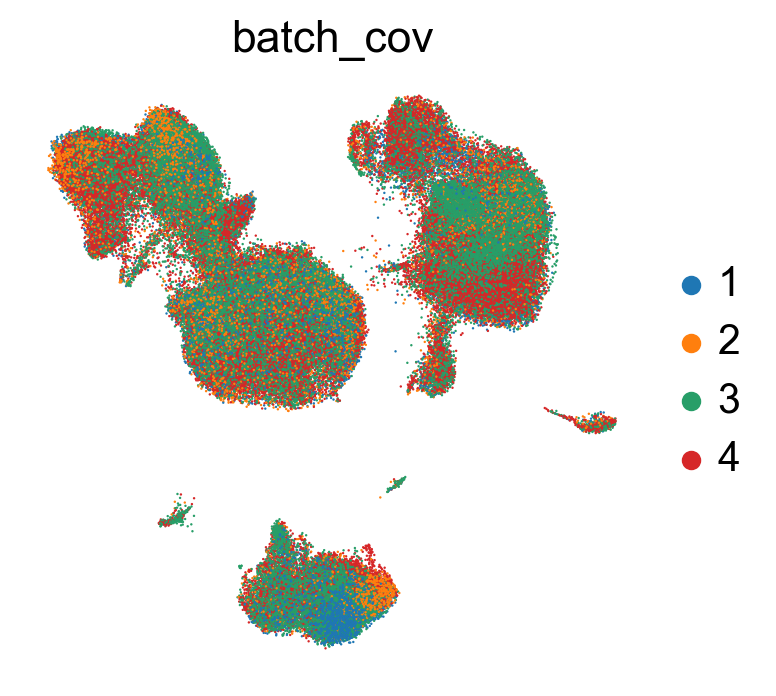

In [9]:
disease_umap = sc.pl.umap(adata, color='batch_cov', size=3,show=True, edgecolor="none", palette=sc.pl.palettes.vega_20_scanpy, save='.batch.png')

## Now, let's make a plot for each of the 16 people in batch 1 as a demo of variability

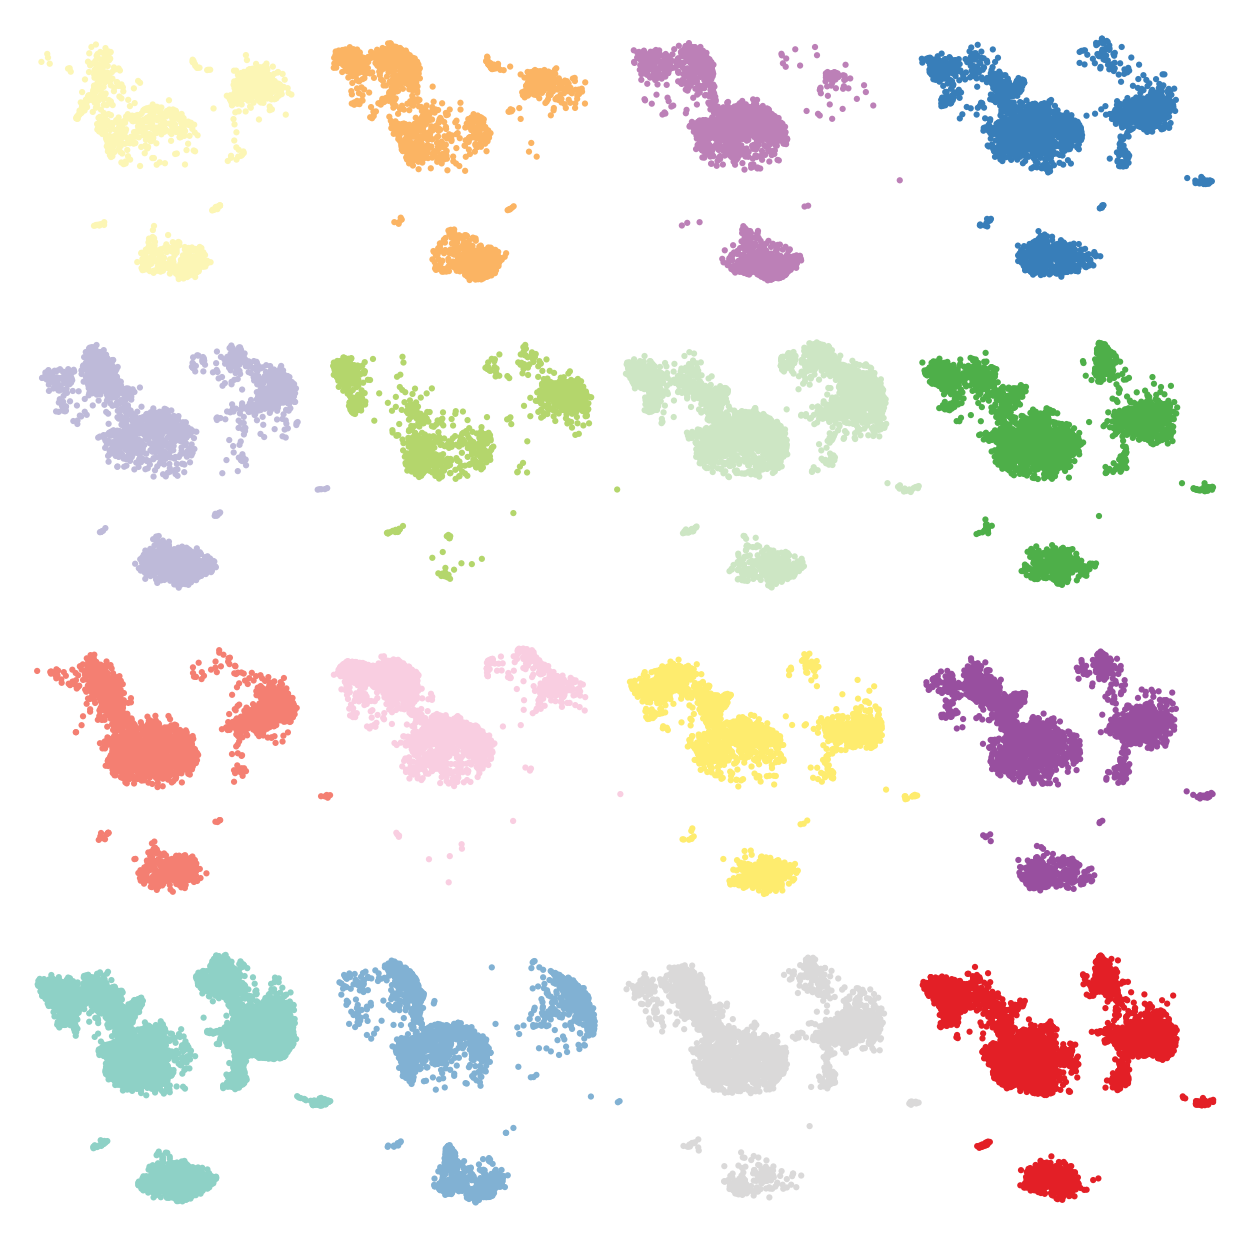

In [10]:
## let's plot 16 plots for the individuals.
colors = ["#8ED1C6","#FCF6B5", "#BEBAD9", "#F47F72", "#81B1D3", "#FBB463", "#B4D66C", "#F9CEE1", "#DAD9D9", "#BC80B7", "#CDE6C4", "#FEEC6E", "#E31F26", "#387EB9", "#4EAF49", "#984F9F", "#8ED1C6","#FCF6B5", "#BEBAD9"];
fig,ax = plt.subplots(nrows=4,ncols=4, figsize=(7,7),sharex=True, sharey=True)
fig.tight_layout()
plt.subplots_adjust(wspace=-0.1, hspace=0)

batch_name = adata.obs.batch_cov.unique()[0]
batch = adata.obs.ind_cov_disease_cov[adata.obs.batch_cov==batch_name].unique();
batch = np.sort(batch.categories.values)
for ind_i in list(range(16)):#list(range(batch.shape[0])):
    ind = batch[ind_i]
    col = colors[ind_i]
    sc.pl.umap(adata[adata.obs.ind_cov_disease_cov==ind,], color = "ind_cov_disease_cov", title=None, palette=[col,col], ax=ax[(ind_i-1)%4,math.floor(ind_i/4)], size=20, edgecolor="none")
    ax[(ind_i-1)%4,math.floor(ind_i/4)].get_xaxis().set_visible(False)
    ax[(ind_i-1)%4,math.floor(ind_i/4)].get_yaxis().set_visible(False)
    ax[(ind_i-1)%4,math.floor(ind_i/4)].get_legend().remove()
    ax[(ind_i-1)%4,math.floor(ind_i/4)].set_title("")
    ax[(ind_i-1)%4,math.floor(ind_i/4)].set_aspect("equal")

fig.savefig(figdir+'/'+batch_name+'_ind.png')

# Rank genes and plot leiden groups

In [11]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished (0:02:13)


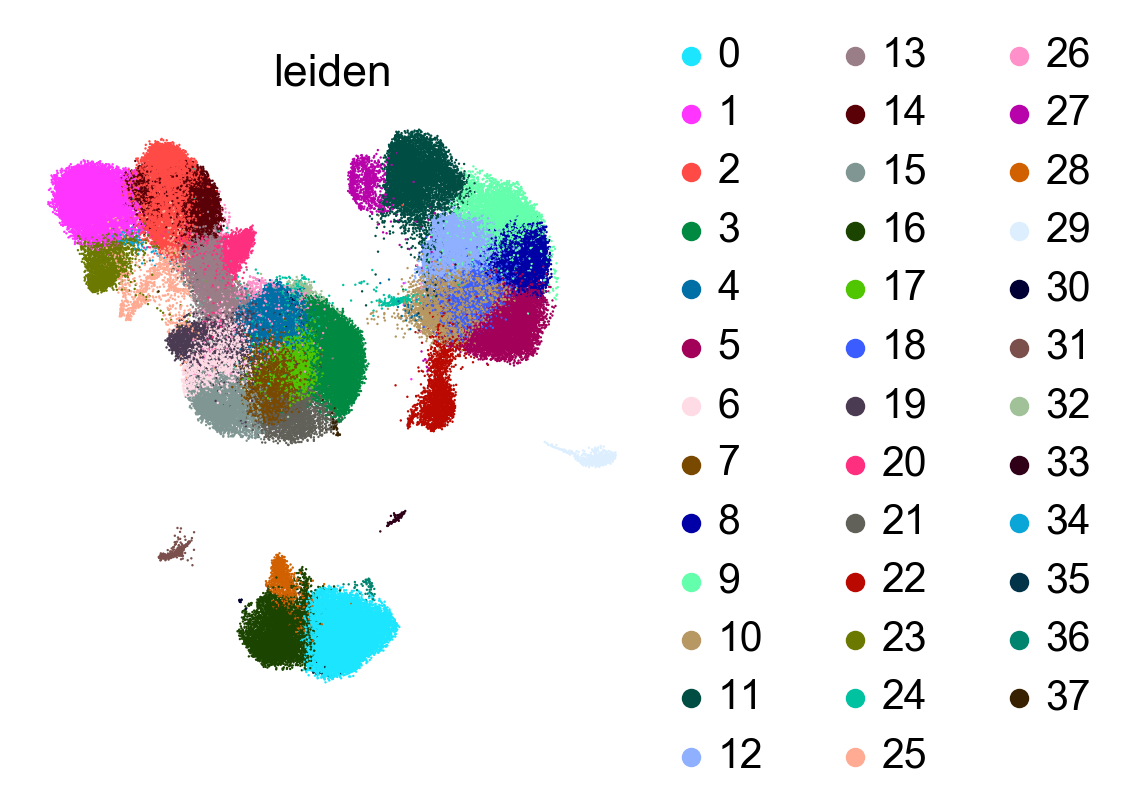

In [12]:
sc.pl.umap(adata, color='leiden', size=3, show=True, edgecolor="none", save='_leiden.png', palette=MASTERCOLORS)

# Most expressed genes per leiden group

In [13]:
pd.set_option('display.max_columns', None)
unique_leiden = np.unique(adata.obs['leiden'].values)
# Compile list of top genes
GeneRanks = pd.DataFrame()
for ii in range(len(unique_leiden)):
    GeneRanks[str('leiden_' + str(ii))] = adata.var_names[np.flipud(np.argsort(np.mean(adata.X[adata.obs['leiden'] == str(ii)], axis=0)))]
GeneRanks.to_csv('FLARE_top_expression.csv')
GeneRanks.head(20)

leiden_0 leiden_1    leiden_2       leiden_3    leiden_4 leiden_5  \
0       TCL1A    KLRF1        GZMH  RP11-291B21.2        CCR7      IL8   
1       CD79A     GZMB      FGFBP2           CD8B        IL7R     IL1B   
2       MS4A1     PRF1        CCL5           CCR7        FHIT     G0S2   
3       CD79B    SPON2        NKG7           CD8A        LEF1  S100A12   
4      VPREB3     GNLY        CST7          S100B   PRKCQ-AS1     CSTA   
5   LINC00926    CLIC3        GZMA           LEF1        CD27    NAMPT   
6       FCER2     NKG7      ZNF683           IL7R         MAL      FOS   
7     HLA-DRA   FGFBP2        GNLY          NUCB2       NUCB2     VCAN   
8       BANK1     CST7        GZMB           CD27      BCL11B     CD14   
9    HLA-DQB1     GZMA        IL32      PRKCQ-AS1  AC013264.2   LGALS2   
10      MEF2C     CTSW       KLRG1          APBA2       EPHB6     CST3   
11       CD22    KLRD1       KLRD1           CPA5        SVIP   MS4A6A   
12   PPAPDC1B    KLRB1  AC092580.4           CD3G     NGFRAP1   TYROBP   
13   HLA-DPA1     HOPX        PRF1            CD7      TMIGD2     FCN1   
14    RALGPS2   IGFBP7    C12orf75           PASK         MYC     GPX1   
15   HLA-DQA1   FCGR3A       PATL2            TXK        CD3G     CCL3   
16   HLA-DPB1    CD247         CD2            MAL      CD40LG     CTSS   
17      FCRL1     CCL4        CD3G         BCL11B       TRAT1     AIF1   
18    TSPAN13   AKR1C3        CD8A            MYC        RGCC     LST1   
19   HLA-DRB1      CD7        CTSW        NGFRAP1        SOX4    PLAUR   

         leiden_6   leiden_7  leiden_8  leiden_9 leiden_10      leiden_11  \
0            IL7R      ADTRP   S100A12    IFITM3   S100A12         CDKN1C   
1           ITGB1      TSHZ2      MNDA  APOBEC3A      VCAN         FCGR3A   
2            IL32       FHIT      VCAN      MNDA      CSTA          MS4A7   
3          CD40LG  PRKCQ-AS1      FCN1    LGALS2      MNDA           HES4   
4           CRIP1     FAM13A      CSTA      FCN1      CD14  RP11-290F20.3   
5           GATA3      TRAT1      CD14      FGL2      CD36           LST1   
6         TNFRSF4        MAL      RBP7      TYMP      FCN1           RHOC   
7            AQP3       CCR7      CST3      IFI6      GPX1          LYPD2   
8            LMNA       IL7R      CTSS      CD14    MS4A6A       SERPINA1   
9   RP11-403A21.2       LEF1    MS4A6A  TNFSF13B      CTSS           AIF1   
10         GPR183    SLC40A1  TNFSF13B      CST3     CSF3R         LILRA3   
11          AP3M2      SOCS2       GRN    MS4A6A      CST3            CFD   
12           RGCC      AP3M2    TYROBP   TNFSF10    TYROBP           CD68   
13            CD2       PIM1     PLBD1      CTSS       FOS           SPI1   
14          FXYD7     BCL11B      GPX1      AIF1     MGST1         IFITM3   
15   RP11-138A9.2        TXK      TYMP  SERPINA1      LST1          HMOX1   
16          TRAT1        MYC    CYP1B1    MARCKS      AIF1            LYN   
17         PIK3R1    NGFRAP1      AIF1       GRN     NEAT1         FCER1G   
18          LPAR6       PDK1   S100A11     ISG15       VIM         STXBP2   
19            VIM       SVIP      CD36    TYROBP     AP1S2         BCL2A1   

   leiden_12 leiden_13 leiden_14      leiden_15     leiden_16   leiden_17  \
0      IL1R2      GZMK      CCL5           IL7R  RP5-887A10.1        CCR7   
1      CD163      CCL5      CMC1        TNFRSF4         MS4A1        IL7R   
2       RETN      LYAR      GZMH           AQP3         BANK1        LEF1   
3    S100A12     DUSP2      NKG7           IL32         CD79A        CD27   
4       VCAN      IL32      GZMA  RP11-403A21.2     TNFRSF13B   PRKCQ-AS1   
5      SAP30     FXYD2      CST7          TRAT1       RALGPS2         MAL   
6     RNASE2    PIK3R1      CCL4          KLRB1    AL928768.3        FHIT   
7       MNDA      CD8B      CD8A         CD40LG           BLK        CD3G   
8       CSTA      IL7R     KLRD1           RORA         CD79B      BCL11B   
9     CLEC4E      CD8A      CD8B           CCR6    AC079767.4 

In [14]:
adata.obs['ct_cov'] = adata.obs['batch_cov'].astype("str")
## do some manual cell type assignment
adata.obs['ct_cov'].loc[adata.obs.leiden == "0"] = "B" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "1"] = "NK" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "2"] = "T8" ## good                                                                                     
adata.obs['ct_cov'].loc[adata.obs.leiden == "3"] = "T8" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "4"] = "T4" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "5"] = "cM" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "6"] = "T4" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "7"] = "T4" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "8"] = "cM" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "9"] = "cM" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "10"] = "cM" ## good                                                                                  
adata.obs['ct_cov'].loc[adata.obs.leiden == "11"] = "ncM" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "12"] = "cM" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "13"] = "T8" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "14"] = "T8" ## good                                                                                  
adata.obs['ct_cov'].loc[adata.obs.leiden == "15"] = "T4" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "16"] = "B" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "17"] = "T4" ## good                                                                                  
adata.obs['ct_cov'].loc[adata.obs.leiden == "18"] = "cM" ## good                                                                              
adata.obs['ct_cov'].loc[adata.obs.leiden == "19"] = "T4" ## good                                                                               
adata.obs['ct_cov'].loc[adata.obs.leiden == "20"] = "T8" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "21"] = "T4" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "22"] = "cDC" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "23"] = "NK" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "24"] = "MK" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "25"] = "ProlifT" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "26"] = "T4" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "27"] = "ncM" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "28"] = "B" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "29"] = "pDC" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "30"] = "T4" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "31"] = "RBC" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "32"] = "T4" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "33"] = "B" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "34"] = "NK" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "35"] = "DB" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "36"] = "B" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "37"] = "Progen" ##
adata.obs['ct_cov'] = adata.obs.ct_cov.astype('category')

sc.settings.set_figure_params(dpi=100, dpi_save=300, format='png', frameon=False, transparent=True, fontsize=16)
plt.rcParams["image.aspect"] = "equal"
MasterORDER = ['cM', 'ncM', 'cDC', 'pDC', 'T4', 'T8', 'NK', 'ProlifT', 'B', 'MK', 'Progen', 'DB', 'RBC']
colorrs = ["#E58606","#5D69B1","#52BCA3","#99C945","#CC61B0","#24796C","#DAA51B","#2F8AC4","#764E9F","#ED645A","#CC3A8E",'#BC23FF', '#D790FF']
adata.obs['ct_cov'] = adata.obs['ct_cov'].cat.reorder_categories(MasterORDER)
adata.uns['ct_cov_colors'] = colorrs
celltype_umap = sc.pl.umap(adata, color='ct_cov', show=True, size=3, edgecolor="none" ,save='_figure6a.png')


/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# 11 populations figure6a and figure6b

In [15]:
## Make proportion plots
adata_obs_small = adata.obs
ind_count = adata_obs_small.groupby(['ind_cov_disease_cov','ct_cov','disease_cov','pop_cov', 'ind_cov'])['ct_cov'].count()
ind_count_sums = ind_count.groupby(level=[0]).sum()
ind_count_sums = ind_count_sums.reset_index(name="counts")
ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc")
# Add weights to WLS
ind_perc['counts'] = ind_count.values.tolist()

ind_perc['ind_count_sum'] = list(np.zeros(len(ind_count.values.tolist()),dtype=int))
# Add total sums per individual to structure
for ii in range(len(ind_count_sums)):
    ind_perc['ind_count_sum'][ind_perc.ind_cov_disease_cov==ind_count_sums.ind_cov_disease_cov[ii]] = ind_count_sums.counts[ii]

## filter samples that have < 100 cells
ind_perc = ind_perc[ind_perc.ind_cov_disease_cov.isin(ind_count_sums.ind_cov_disease_cov[ind_count_sums.counts > 100])]

cg_cov = pd.DataFrame( {    'ct_cov':['pDC', 'iM',   'compM', 'NKCD16-', 'NKCD16+', 'Batypical', 'DB',      'Progen',  'Th',    'Bplasma', 'Bmem',  'Bnaive', 'cM',   'ncM',  'iM',  'T4naive', 'Macro', 'T4mem', 'T8mem', 'T8em cyto1','T4IFN', 'T8em cyto2', 'T8em cyto3', 'T8naive', 'Treg',  'NK',    'ProlifT', 'Tc1q+', 'cDC', 'RBC'], 
                          'ct_group':['mono', 'mono', 'mono',  'lymph',   'lymph',   'lymph',     'Doublet', 'Progen',  'lymph', 'lymph',   'lymph', 'lymph',  'mono', 'mono', 'mono','lymph',   'mono',  'lymph', 'lymph', 'lymph',     'lymph', 'lymph',      'lymph',      'lymph',   'lymph', 'lymph', 'lymph',   'lymph', 'mono','RBC']})

# Add cell type macrogroup as observation
adata.obs['ct_group'] = adata.obs['ct_cov'].tolist()
celltypes = np.unique(cg_cov['ct_cov'].tolist())
for ii in range(len(celltypes)):
    adata.obs['ct_group'][adata.obs['ct_cov']==cg_cov['ct_cov'][ii]] = cg_cov['ct_group'][ii]

ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_count_sums.ind_cov_disease_cov = ind_count_sums.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_perc = ind_perc.set_index('ct_cov').join(cg_cov.set_index('ct_cov'))
ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.astype("str")
ind_perc.reset_index(inplace=True)
ind_perc.ct_cov = ind_perc.ct_cov.astype('category')
ind_perc.ct_cov = ind_perc.ct_cov.cat.reorder_categories(adata.obs.ct_cov.cat.categories.values)

perc_plot = sns.catplot(x='disease_cov', y='ct_perc', order=[ "Healthy", "Managed", "Treated", "Flare"], hue='ct_cov', data=ind_perc, kind='violin', col_order=MasterORDER, col='ct_cov', col_wrap=4, cut=0, dodge=False, aspect=0.5, sharex=False, sharey=False, palette=colorrs)

for ct_i in list(range(len(MasterORDER))):
    ct = MasterORDER[ct_i]
    sns.stripplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], order=[ "Healthy", "Managed", "Treated", "Flare"], color="0", size=10, ax=perc_plot.axes[ct_i], jitter=False)
    try:
        sns.pointplot(x="disease_cov", y="ct_perc", hue="ind_cov", data=ind_perc[ind_perc.ct_cov == ct], order=[ "Healthy", "Managed", "Treated", "Flare"], color="0", scale=0.5, ax=perc_plot.axes[ct_i])
    except:
        continue
    perc_plot.axes[ct_i].get_yaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_xaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_legend().remove()
    perc_plot.set_xticklabels(rotation=90)
    perc_plot.fig.subplots_adjust(wspace=0.7, hspace = 0.7)
    
perc_plot.savefig(figdir+"/violin.ct_cov_figure6b.png")
perc_plot.savefig(figdir+"/violin.ct_cov_figure6b.pdf")

def highlight(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    # bonferroni correction
    sig = data < (0.05/len(data))
    return [attr if v else '' for v in sig]

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Managed WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Managed'])]
HEALTHYMANAGED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Managed"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYMANAGED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Treated WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Treated'])]
HEALTHYTREATED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Treated"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYTREATED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)


# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Flare WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Flare'])]
HEALTHYFLARE_effect = {}
HEALTHYFLARE_FC = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Flare"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYFLARE_effect[ct] = effect
    HEALTHYFLARE_FC[ct] = math.log2(sum(est.params)/est.params[0])
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Treated vs. Flare WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Treated', 'Flare'])]
TREATEDFLARE_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Flare"] = 0
    disease.values[disease=="Treated"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    TREATEDFLARE_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Treated vs. Managed WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Treated', 'Managed'])]
TREATEDMANAGED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Managed"] = 0
    disease.values[disease=="Treated"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    TREATEDMANAGED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. SLE WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Treated', 'Untreated', 'Managed'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease!="Healthy"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


as a proportion of total PBMC: Healthy vs. Managed WEIGHTED BY TOTAL PBMC COUNTS


/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


as a proportion of total PBMC: Healthy vs. Treated WEIGHTED BY TOTAL PBMC COUNTS


as a proportion of total PBMC: Healthy vs. Flare WEIGHTED BY TOTAL PBMC COUNTS


as a proportion of total PBMC: Treated vs. Flare WEIGHTED BY TOTAL PBMC COUNTS


as a proportion of total PBMC: Treated vs. Managed WEIGHTED BY TOTAL PBMC COUNTS


as a proportion of total PBMC: Healthy vs. SLE WEIGHTED BY TOTAL PBMC COUNTS


In [16]:
ct = 'cM'
print('Healthy')
display(ind_perc[ind_perc.disease_cov=='Healthy'][ind_perc.ct_cov==ct].ct_perc.mean())
print('Flare')
display(ind_perc[ind_perc.disease_cov=='Flare'][ind_perc.ct_cov==ct].ct_perc.mean())
print(ind_perc[ind_perc.disease_cov=='Healthy'][ind_perc.ct_cov==ct].ct_perc.mean() - ind_perc[ind_perc.disease_cov=='Flare'][ind_perc.ct_cov==ct].ct_perc.mean())



Healthy


/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


18.97608006498529

Flare


/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


26.289599610498932

-7.313519545513643


/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [17]:
print((np.unique(adata.obs['ind_cov'][adata.obs['disease_cov']=='Flare'].tolist())))
len(np.unique(adata.obs['ind_cov'][adata.obs['disease_cov']=='Flare'].tolist()))

['FLARE002' 'FLARE003' 'FLARE004' 'FLARE005' 'FLARE006' 'FLARE007'
 'FLARE008' 'FLARE009' 'FLARE011' 'FLARE013' 'FLARE014' 'FLARE015'
 'FLARE016' 'FLARE017' 'FLARE018' 'FLARE019' 'FLARE020']


17

# Effect size scatter plot

In [19]:
MasterORDER = ['cM', 'ncM', 'cDC', 'pDC', 'T4', 'T8', 'NK', 'ProlifT', 'B', 'MK', 'Progen', 'DB', 'RBC']
colorrs = ["#E58606","#5D69B1","#52BCA3","#99C945","#CC61B0","#24796C","#DAA51B","#2F8AC4","#764E9F","#ED645A","#CC3A8E"]

# Generate dictionary containing values from cross-sectional dataset.
CROSSTRHEALTHY = {'cM':-10.741421310745048, 'ncM':-1.6742194009077185, 'cDC':0.13125795717366492, 'pDC':0.5457223411567755, 'T4':13.335545671765423, 'T8':-1.3251414780715685, 'NK':0.3014028252276574, 'ProlifT':-0.33624304888249434, 'B':-0.1872977778483561, 'MK':-0.16963446346876693, 'Progen':-0.00949716664002322}
Comparison_plot_data = pd.DataFrame({'UNT/HEALTHY':pd.Series(HEALTHYFLARE_effect), 'Cross_TR/HEALTHY':pd.Series(CROSSTRHEALTHY)})
Comparison_plot_data = Comparison_plot_data.reindex(MasterORDER)
Comparison_plot_data = Comparison_plot_data.dropna()
Comparison_plot_data['Cell Type'] = Comparison_plot_data.index
Comparison_plot_data['UNT/HEALTHY'] = Comparison_plot_data['UNT/HEALTHY'].abs()
Comparison_plot_data['Cross_TR/HEALTHY'] = Comparison_plot_data['Cross_TR/HEALTHY'].abs()
display(Comparison_plot_data)
ax = sns.scatterplot(x="UNT/HEALTHY", y="Cross_TR/HEALTHY", hue='Cell Type', data=Comparison_plot_data, s=100, marker="o", palette=colorrs)
line = np.linspace(0.001, 20, 10)
ax = plt.plot(line, line, color='k')
ax = plt.axis('equal')
ax = plt.xlabel('Beta Flare/Healthy')
ax = plt.ylabel('Beta Cross-Sectional Treated/Healthy')
ax = plt.yscale('log')
ax = plt.xscale('log')
ax = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax = plt.savefig(figdir+'/Flare-Healthy_Effect_size_scatterplot.pdf')
ax = plt.savefig(figdir='/Flare-Healthy_Effect_size_scatterplot.png')
print(Comparison_plot_data.corr(method='pearson'))


UNT/HEALTHY  Cross_TR/HEALTHY Cell Type
cM          4.667405         10.741421        cM
ncM         0.642638          1.674219       ncM
cDC         1.141736          0.131258       cDC
pDC         0.530743          0.545722       pDC
T4         11.439907         13.335546        T4
T8          8.141561          1.325141        T8
NK          0.350053          0.301403        NK
ProlifT     0.859051          0.336243   ProlifT
B           1.030926          0.187298         B
MK          0.504237          0.169634        MK
Progen      0.015301          0.009497    Progen

ValueError: math domain error

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f9a41543f80> (for post_execute):


ValueError: math domain error

ValueError: math domain error

<Figure size 400x400 with 1 Axes>

# Fold change scatter plot

UNT/HEALTHY  Cross_TR/HEALTHY Cell Type
cM         -0.327545         -0.688771        cM
ncM         0.277092         -0.558104       ncM
cDC         1.383541          0.147678       cDC
pDC         1.657982          1.380221       pDC
T4          0.589506          0.656980        T4
T8         -0.509287         -0.100498        T8
NK          0.068253          0.058098        NK
ProlifT    -1.906668         -1.101802   ProlifT
B          -0.113015         -0.021202         B
MK          0.769564         -1.276796        MK
Progen      0.416402         -0.162151    Progen

                  UNT/HEALTHY  Cross_TR/HEALTHY
UNT/HEALTHY          1.000000          0.598619
Cross_TR/HEALTHY     0.598619          1.000000


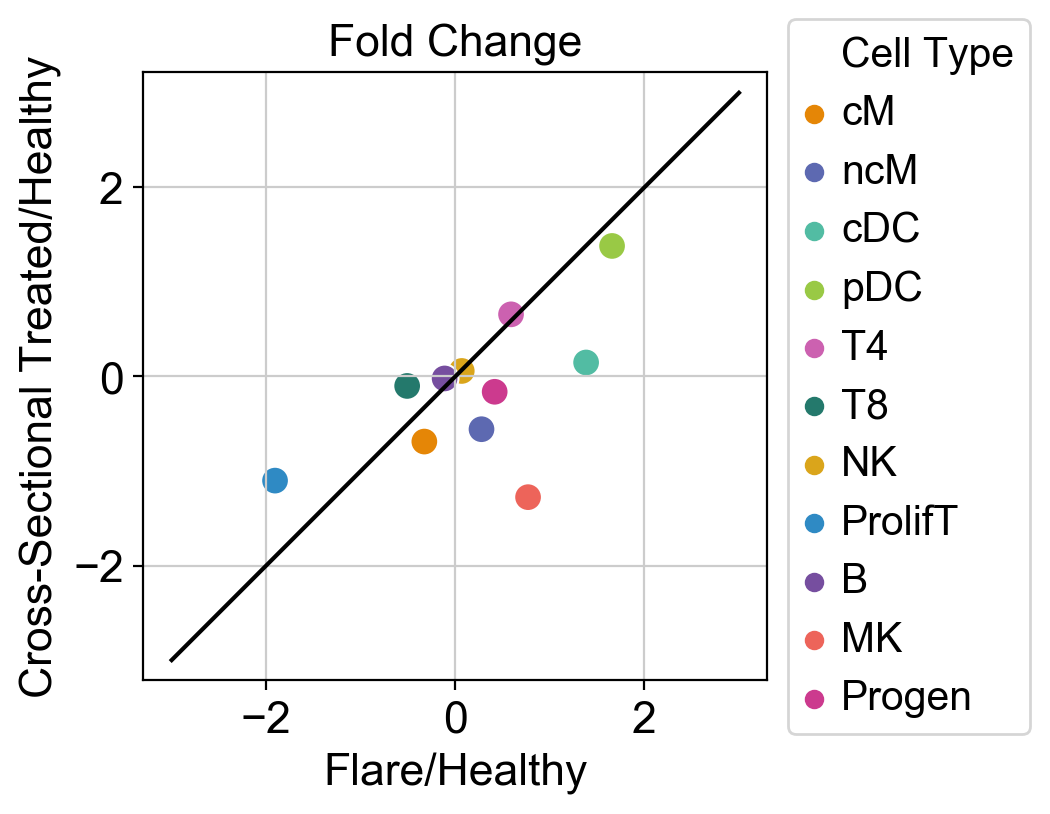

In [21]:
MasterORDER = ['cM', 'ncM', 'cDC', 'pDC', 'T4', 'T8', 'NK', 'ProlifT', 'B', 'MK', 'Progen', 'DB', 'RBC']
colorrs = ["#E58606","#5D69B1","#52BCA3","#99C945","#CC61B0","#24796C","#DAA51B","#2F8AC4","#764E9F","#ED645A","#CC3A8E"]

# Generate dictionary containing values from cross-sectional dataset.
CROSSTRHEALTHY = {'cM':  -0.6887710566546117, 'ncM':-0.5581042433372936, 'cDC':0.14767770138323252, 'pDC':1.3802206455290076, 'T4':0.6569801055457304, 'T8':-0.10049816214039477, 'NK':0.05809782022507549, 'ProlifT':-1.1018015246975479, 'B':-0.021202215692427216, 'MK':-1.27679599270261, 'Progen':-0.16215092601029488}
Comparison_plot_data = pd.DataFrame({'UNT/HEALTHY':pd.Series(HEALTHYFLARE_FC), 'Cross_TR/HEALTHY':pd.Series(CROSSTRHEALTHY)})
Comparison_plot_data = Comparison_plot_data.reindex(MasterORDER)
Comparison_plot_data = Comparison_plot_data.dropna()
Comparison_plot_data['Cell Type'] = Comparison_plot_data.index
display(Comparison_plot_data)
ax = sns.scatterplot(x="UNT/HEALTHY", y="Cross_TR/HEALTHY", hue='Cell Type', data=Comparison_plot_data, s=100, marker="o", palette=colorrs)
line = np.linspace(-3, 3, 10)
ax = plt.plot(line, line, color='k')
ax = plt.axis('equal')
ax = plt.xlabel('Flare/Healthy')
ax = plt.ylabel('Cross-Sectional Treated/Healthy')
ax = plt.title('Fold Change')
ax = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax = plt.savefig(figdir+'/Flare-Healthy_FC_scatterplot.pdf')
ax = plt.savefig(figdir+'/Flare-Healthy_FC_scatterplot.png')
print(Comparison_plot_data.corr(method='pearson'))


In [22]:
Group1 = Comparison_plot_data['UNT/HEALTHY'].tolist()
Group2 = Comparison_plot_data['Cross_TR/HEALTHY'].tolist()
stats.pearsonr(Group1, Group2)

(0.5986190799051134, 0.05168056937458715)

# Rituximab patients abundance before & after treatment

0
1729


/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'\nfrom scipy.stats import stats\n# First three are from flare\nB_Untreated = [20.207254, 51.113940, 11.088168]\n#B_Untreated = [390, 803, 537]\n#B_Treated =   [0,         0.700280,  0.143143]\n#B_Treated =   [0,         0.700280,  0.143143, 0.025517, 0.054765]\nB_Treated =   [0,         0.700280,  0.143143, 0.025517, 0.054765, 27.407201]\n#B_Treated = [0, 5, 5, 1, 2, 982]\nprint(np.mean(B_Untreated))\nprint(np.mean(B_Treated))\nstats.ranksums(B_Untreated, B_Treated)\n'

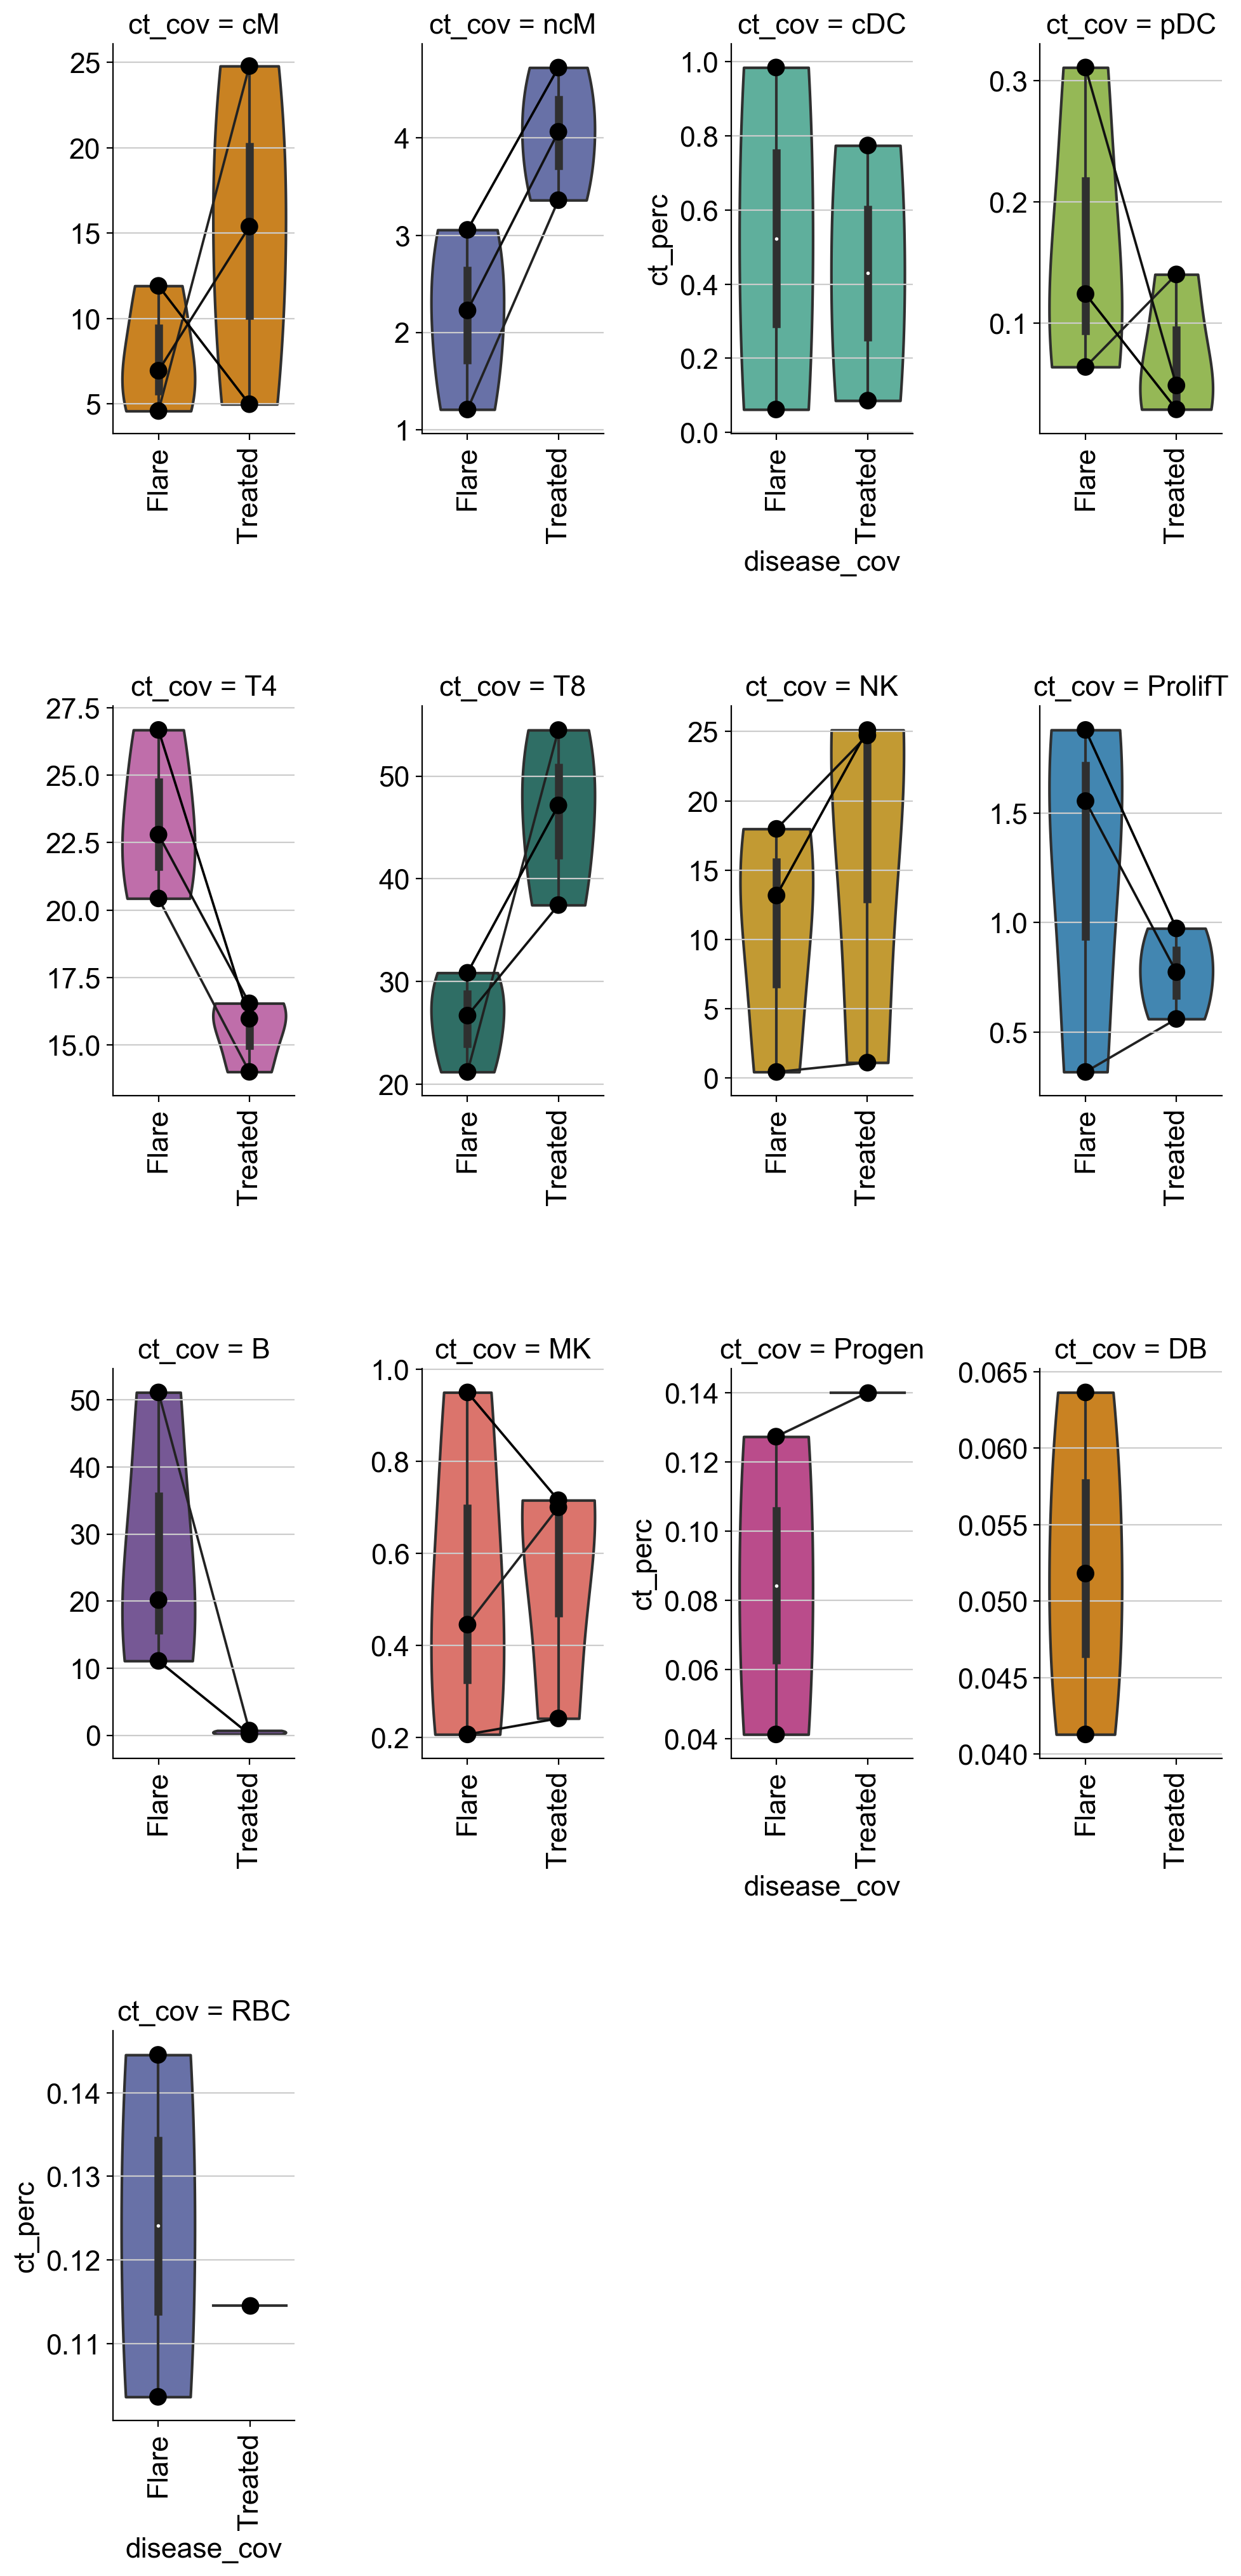

In [23]:
cdata = adata[adata.obs['ind_cov'].isin(['FLARE013', 'FLARE002', 'FLARE003'])]

ddata=cdata[cdata.obs['ct_cov']=='B']
print(np.sum(ddata.obs['disease_cov']=='Healthy'))
print(np.sum(ddata.obs['disease_cov']=='Flare'))

## Make proportion plots
adata_obs_small = cdata.obs
ind_count = adata_obs_small.groupby(['ind_cov_disease_cov','ct_cov','disease_cov','pop_cov', 'ind_cov'])['ct_cov'].count()
ind_count_sums = ind_count.groupby(level=[0]).sum()
ind_count_sums = ind_count_sums.reset_index(name="counts")
ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc")
# Add weights to WLS
ind_perc['counts'] = ind_count.values.tolist()

ind_perc['ind_count_sum'] = list(np.zeros(len(ind_count.values.tolist()),dtype=int))
# Add total sums per individual to structure
for ii in range(len(ind_count_sums)):
    ind_perc['ind_count_sum'][ind_perc.ind_cov_disease_cov==ind_count_sums.ind_cov_disease_cov[ii]] = ind_count_sums.counts[ii]

## filter samples that have < 100 cells
ind_perc = ind_perc[ind_perc.ind_cov_disease_cov.isin(ind_count_sums.ind_cov_disease_cov[ind_count_sums.counts > 100])]

cg_cov = pd.DataFrame( {    'ct_cov':['pDC', 'iM',   'compM', 'NKCD16-', 'NKCD16+', 'Batypical', 'DB',      'Progen',  'Th',    'Bplasma', 'Bmem',  'Bnaive', 'cM',   'ncM',  'iM',  'T4naive', 'Macro', 'T4mem', 'T8mem', 'T8em cyto1','T4IFN', 'T8em cyto2', 'T8em cyto3', 'T8naive', 'Treg',  'NK',    'ProlifT', 'Tc1q+', 'cDC', 'RBC'], 
                          'ct_group':['mono', 'mono', 'mono',  'lymph',   'lymph',   'lymph',     'Doublet', 'Progen',  'lymph', 'lymph',   'lymph', 'lymph',  'mono', 'mono', 'mono','lymph',   'mono',  'lymph', 'lymph', 'lymph',     'lymph', 'lymph',      'lymph',      'lymph',   'lymph', 'lymph', 'lymph',   'lymph', 'mono','RBC']})

# Add cell type macrogroup as observation
adata.obs['ct_group'] = adata.obs['ct_cov'].tolist()
celltypes = np.unique(cg_cov['ct_cov'].tolist())
for ii in range(len(celltypes)):
    adata.obs['ct_group'][adata.obs['ct_cov']==cg_cov['ct_cov'][ii]] = cg_cov['ct_group'][ii]

ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_count_sums.ind_cov_disease_cov = ind_count_sums.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_perc = ind_perc.set_index('ct_cov').join(cg_cov.set_index('ct_cov'))
ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.astype("str")
ind_perc.reset_index(inplace=True)
ind_perc.ct_cov = ind_perc.ct_cov.astype('category')
ind_perc.ct_cov = ind_perc.ct_cov.cat.reorder_categories(adata.obs.ct_cov.cat.categories.values)

perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov', data=ind_perc, kind='violin', col_order=MasterORDER, col='ct_cov', col_wrap=4, cut=0, dodge=False, aspect=0.5, sharex=False, sharey=False, palette=colorrs)

for ct_i in list(range(len(MasterORDER))):
    ct = MasterORDER[ct_i]
    sns.stripplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color="0", size=10, ax=perc_plot.axes[ct_i], jitter=False)
    try:
        sns.pointplot(x="disease_cov", y="ct_perc", hue="ind_cov", data=ind_perc[ind_perc.ct_cov == ct], color="0", scale=0.5, ax=perc_plot.axes[ct_i])
    except:
        continue
    perc_plot.axes[ct_i].get_yaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_xaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_legend().remove()
    perc_plot.set_xticklabels(rotation=90)
    perc_plot.fig.subplots_adjust(wspace=0.7, hspace = 0.7)
    
perc_plot.savefig(figdir+"/violin.rituximab.pdf")

'''
from scipy.stats import stats
# First three are from flare
B_Untreated = [20.207254, 51.113940, 11.088168]
#B_Untreated = [390, 803, 537]
#B_Treated =   [0,         0.700280,  0.143143]
#B_Treated =   [0,         0.700280,  0.143143, 0.025517, 0.054765]
B_Treated =   [0,         0.700280,  0.143143, 0.025517, 0.054765, 27.407201]
#B_Treated = [0, 5, 5, 1, 2, 982]
print(np.mean(B_Untreated))
print(np.mean(B_Treated))
stats.ranksums(B_Untreated, B_Treated)
'''    



# Feature plots for Untreated Treated pairs

In [24]:
pairs = ['FLARE004', 'FLARE009', 'FLARE011', 'FLARE013', 'FLARE016', 'FLARE003', 'FLARE002', 'FLARE008']
colors = ["#000000", "#FF0000"]
for pair in pairs:
    bdata = adata[adata.obs['ind_cov']==pair]
    print(pair)
    sc.pl.umap(bdata, size=10, show=False, color='disease_cov', save=str('TREATED_UNTREATED_PAIR'+ pair + '.disease.png'), palette=colors)
    plt.show()
    

Trying to set attribute `.obs` of view, making a copy.


FLARE004


... storing 'ct_group' as categorical


Trying to set attribute `.obs` of view, making a copy.


FLARE009


... storing 'ct_group' as categorical


Trying to set attribute `.obs` of view, making a copy.


FLARE011


... storing 'ct_group' as categorical


Trying to set attribute `.obs` of view, making a copy.


FLARE013


... storing 'ct_group' as categorical


Trying to set attribute `.obs` of view, making a copy.


FLARE016


... storing 'ct_group' as categorical


Trying to set attribute `.obs` of view, making a copy.


FLARE003


... storing 'ct_group' as categorical


Trying to set attribute `.obs` of view, making a copy.


FLARE002


... storing 'ct_group' as categorical


Trying to set attribute `.obs` of view, making a copy.


FLARE008


... storing 'ct_group' as categorical


# Higher resolution subpopulation labeling

/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
... storing 'ct_group' as categorical


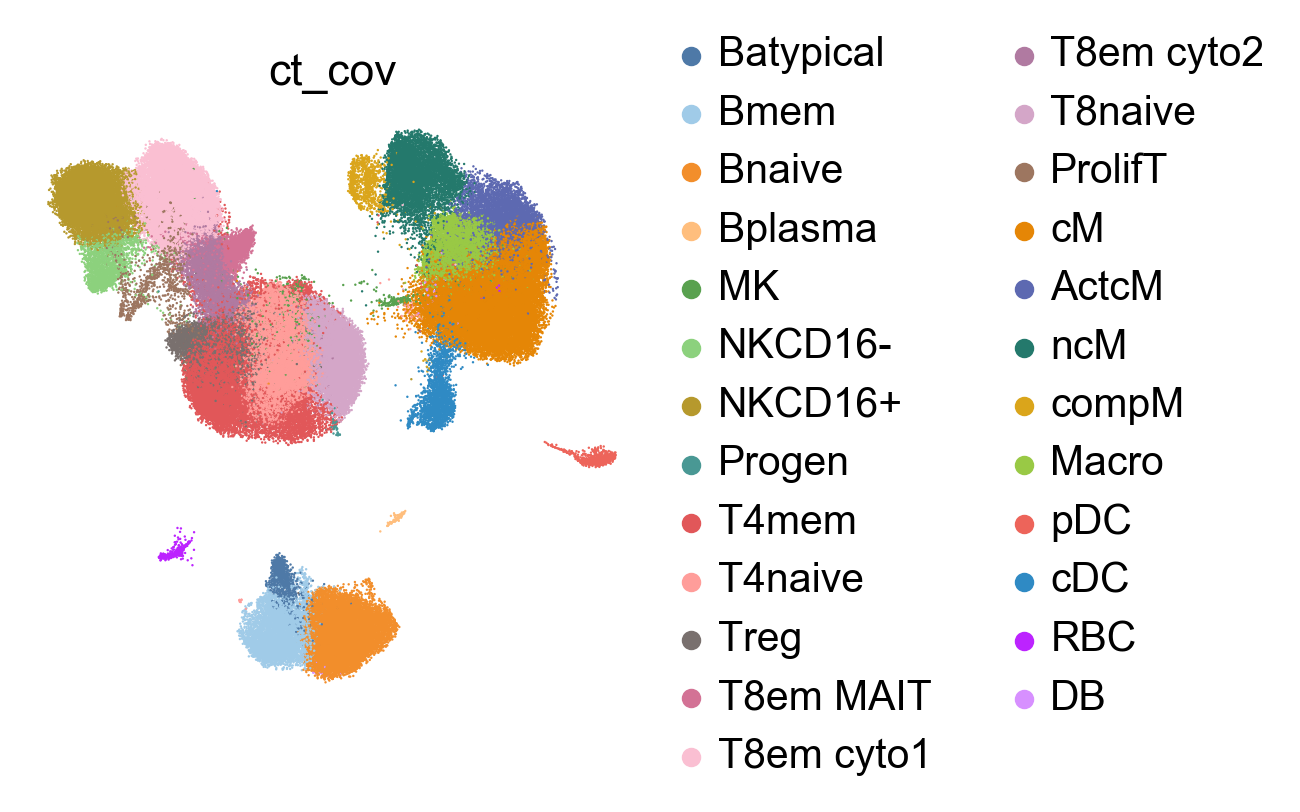

In [25]:
adata.obs['ct_cov'] = adata.obs['ct_cov'].astype('object')
# # ## do some manual cell type assignment
adata.obs['ct_cov'].loc[adata.obs.leiden == "0"] = "Bnaive" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "1"] = "NKCD16+" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "2"] = "T8em cyto1" ## good                                                                                     
adata.obs['ct_cov'].loc[adata.obs.leiden == "3"] = "T8naive" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "4"] = "T4naive" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "5"] = "cM" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "6"] = "T4mem" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "7"] = "T4naive" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "8"] = "cM" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "9"] = "ActcM" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "10"] = "cM" ## good                                                                                  
adata.obs['ct_cov'].loc[adata.obs.leiden == "11"] = "ncM" ## good                                                                                    
adata.obs['ct_cov'].loc[adata.obs.leiden == "12"] = "Macro" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "13"] = "T8em cyto2" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "14"] = "T8em cyto1" ## good                                                                                  
adata.obs['ct_cov'].loc[adata.obs.leiden == "15"] = "T4mem" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "16"] = "Bmem" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "17"] = "T4naive" ## good                                                                                  
adata.obs['ct_cov'].loc[adata.obs.leiden == "18"] = "cM" ## good                                                                              
adata.obs['ct_cov'].loc[adata.obs.leiden == "19"] = "Treg" ## good                                                                               
adata.obs['ct_cov'].loc[adata.obs.leiden == "20"] = "T8em MAIT" ## good                                                                                   
adata.obs['ct_cov'].loc[adata.obs.leiden == "21"] = "T4mem" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "22"] = "cDC" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "23"] = "NKCD16-" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "24"] = "MK" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "25"] = "ProlifT" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "26"] = "T4mem" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "27"] = "compM" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "28"] = "Batypical" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "29"] = "pDC" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "30"] = "T4naive" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "31"] = "RBC" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "32"] = "T4mem" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "33"] = "Bplasma" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "34"] = "NKCD16-" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "35"] = "DB" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "36"] = "Bnaive" ##
adata.obs['ct_cov'].loc[adata.obs.leiden == "37"] = "Progen" ##
adata.obs['ct_cov'] = adata.obs.ct_cov.astype('category')
sc.settings.set_figure_params(dpi=100, dpi_save=300, format='png', frameon=False, transparent=True, fontsize=16)
plt.rcParams["image.aspect"] = "equal"
MasterORDER = ['Batypical', 'Bmem', 'Bnaive', 'Bplasma', 'MK', 'NKCD16-', 'NKCD16+', 'Progen', 'T4mem', 'T4naive', 'Treg', 'T8em MAIT', 'T8em cyto1', 'T8em cyto2', 'T8naive', 'ProlifT', 'cM', 'ActcM', 'ncM', 'compM', 'Macro', 'pDC', 'cDC', 'RBC', 'DB']
colorrs = ["#4E79A7","#A0CBE8","#F28E2B","#FFBE7D","#59A14F","#8CD17D","#B6992D","#499894","#E15759","#FF9D9A","#79706E","#D37295","#FABFD2","#B07AA1","#D4A6C8","#9D7660",
                 "#E58606", "#5D69B1", "#24796C", '#DAA51B', '#99C945', '#ED645A', '#2F8AC4', '#BC23FF', '#D790FF']

adata.obs['ct_cov'] = adata.obs['ct_cov'].cat.reorder_categories(MasterORDER)
adata.uns['ct_cov_colors'] = colorrs
celltype_umap = sc.pl.umap(adata, color='ct_cov', size=3, show=True, edgecolor="none", save='.figure6c.png', palette=colorrs)


# Statistics

In [26]:
## Make proportion plots
adata_obs_small = adata.obs
ind_count = adata_obs_small.groupby(['ind_cov_disease_cov','ct_cov','disease_cov','pop_cov', 'ind_cov'])['ct_cov'].count()
ind_count_sums = ind_count.groupby(level=[0]).sum()
ind_count_sums = ind_count_sums.reset_index(name="counts")
ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc")
# Add weights to WLS
ind_perc['counts'] = ind_count.values.tolist()

ind_perc['ind_count_sum'] = list(np.zeros(len(ind_count.values.tolist()),dtype=int))
# Add total sums per individual to structure
for ii in range(len(ind_count_sums)):
    ind_perc['ind_count_sum'][ind_perc.ind_cov_disease_cov==ind_count_sums.ind_cov_disease_cov[ii]] = ind_count_sums.counts[ii]


## filter samples that have < 100 cells
ind_perc = ind_perc[ind_perc.ind_cov_disease_cov.isin(ind_count_sums.ind_cov_disease_cov[ind_count_sums.counts > 100])]

cg_cov = pd.DataFrame( {    'ct_cov':['ActcM','pDC', 'infM',   'compM', 'NKCD16-', 'NKCD16+', 'Batypical', 'DB',      'Progen',  'Th',    'Bplasma', 'Bmem',  'Bnaive', 'cM',   'ncM',  'iM',  'T4naive', 'Macro', 'T4mem', 'T8mem', 'T8em cyto1','T4IFN', 'T8em cyto2', 'T8em MAIT', 'T8naive', 'Treg',  'NK',    'ProlifT', 'Tc1q+', 'cDC', 'RBC'], 
                          'ct_group':['mono','mono', 'mono', 'mono',  'lymph',   'lymph',   'lymph',     'Doublet', 'Progrenitor',  'lymph', 'lymph',   'lymph', 'lymph',  'mono', 'mono', 'mono','lymph',   'mono',  'lymph', 'lymph', 'lymph',     'lymph', 'lymph',      'lymph',      'lymph',   'lymph', 'lymph', 'lymph',   'lymph', 'mono','RBC']})

# Add cell type macrogroup as observation
adata.obs['ct_group'] = adata.obs['ct_cov'].tolist()
celltypes = np.unique(cg_cov['ct_cov'].tolist())
for ii in range(len(celltypes)):
    adata.obs['ct_group'][adata.obs['ct_cov']==cg_cov['ct_cov'][ii]] = cg_cov['ct_group'][ii]

ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_count_sums.ind_cov_disease_cov = ind_count_sums.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_perc = ind_perc.set_index('ct_cov').join(cg_cov.set_index('ct_cov'))
ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.astype("str")
ind_perc.reset_index(inplace=True)
ind_perc.ct_cov = ind_perc.ct_cov.astype('category')
ind_perc.ct_cov = ind_perc.ct_cov.cat.reorder_categories(adata.obs.ct_cov.cat.categories.values)

def highlight(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    # bonferroni correction
    sig = data < (0.05/len(data))
    return [attr if v else '' for v in sig]

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Managed WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Managed'])]
HEALTHYMANAGED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Managed"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYMANAGED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Treated WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Treated'])]
HEALTHYTREATED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Treated"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYTREATED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)


# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Flare WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Flare'])]
HEALTHYFLARE_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Flare"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYFLARE_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Treated vs. Flare WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Treated', 'Flare'])]
TREATEDFLARE_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Flare"] = 0
    disease.values[disease=="Treated"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    TREATEDFLARE_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Treated vs. Managed WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Treated', 'Managed'])]
TREATEDMANAGED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Managed"] = 0
    disease.values[disease=="Treated"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    TREATEDMANAGED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. SLE WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Treated', 'Untreated', 'Managed'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease!="Healthy"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Treated&Flare WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Treated', 'Untreated'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease!="Healthy"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


as a proportion of total PBMC: Healthy vs. Managed WEIGHTED BY TOTAL PBMC COUNTS


/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


as a proportion of total PBMC: Healthy vs. Treated WEIGHTED BY TOTAL PBMC COUNTS


as a proportion of total PBMC: Healthy vs. Flare WEIGHTED BY TOTAL PBMC COUNTS


as a proportion of total PBMC: Treated vs. Flare WEIGHTED BY TOTAL PBMC COUNTS


as a proportion of total PBMC: Treated vs. Managed WEIGHTED BY TOTAL PBMC COUNTS


as a proportion of total PBMC: Healthy vs. SLE WEIGHTED BY TOTAL PBMC COUNTS


as a proportion of total PBMC: Healthy vs. Treated&Flare WEIGHTED BY TOTAL PBMC COUNTS


In [27]:
ct = 'Macro'
print('Healthy')
display(ind_perc[ind_perc.disease_cov=='Healthy'][ind_perc.ct_cov==ct].ct_perc.mean())
print('Flare')
display(ind_perc[ind_perc.disease_cov=='Flare'][ind_perc.ct_cov==ct].ct_perc.mean())
print(ind_perc[ind_perc.disease_cov=='Healthy'][ind_perc.ct_cov==ct].ct_perc.mean() - ind_perc[ind_perc.disease_cov=='Flare'][ind_perc.ct_cov==ct].ct_perc.mean())


Healthy


/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


0.23388239513693646

Flare


/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


7.948139236838353

-7.714256841701416


/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [28]:
print('Healthy')
healthy = ind_perc[ind_perc.disease_cov=='Healthy'][ind_perc.ct_cov=='Macro'].ct_perc.tolist()
print('Flare')
flare = ind_perc[ind_perc.disease_cov=='Flare'][ind_perc.ct_cov=='Macro'].ct_perc.tolist()
display(stats.ranksums(healthy, flare))
#(ind_perc.disease_cov=='Flare') | (ind_perc.disease_cov=='Treated')

Healthy
Flare


/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


RanksumsResult(statistic=-3.9984317860137173, pvalue=6.376355162620772e-05)

# Lymphocytes

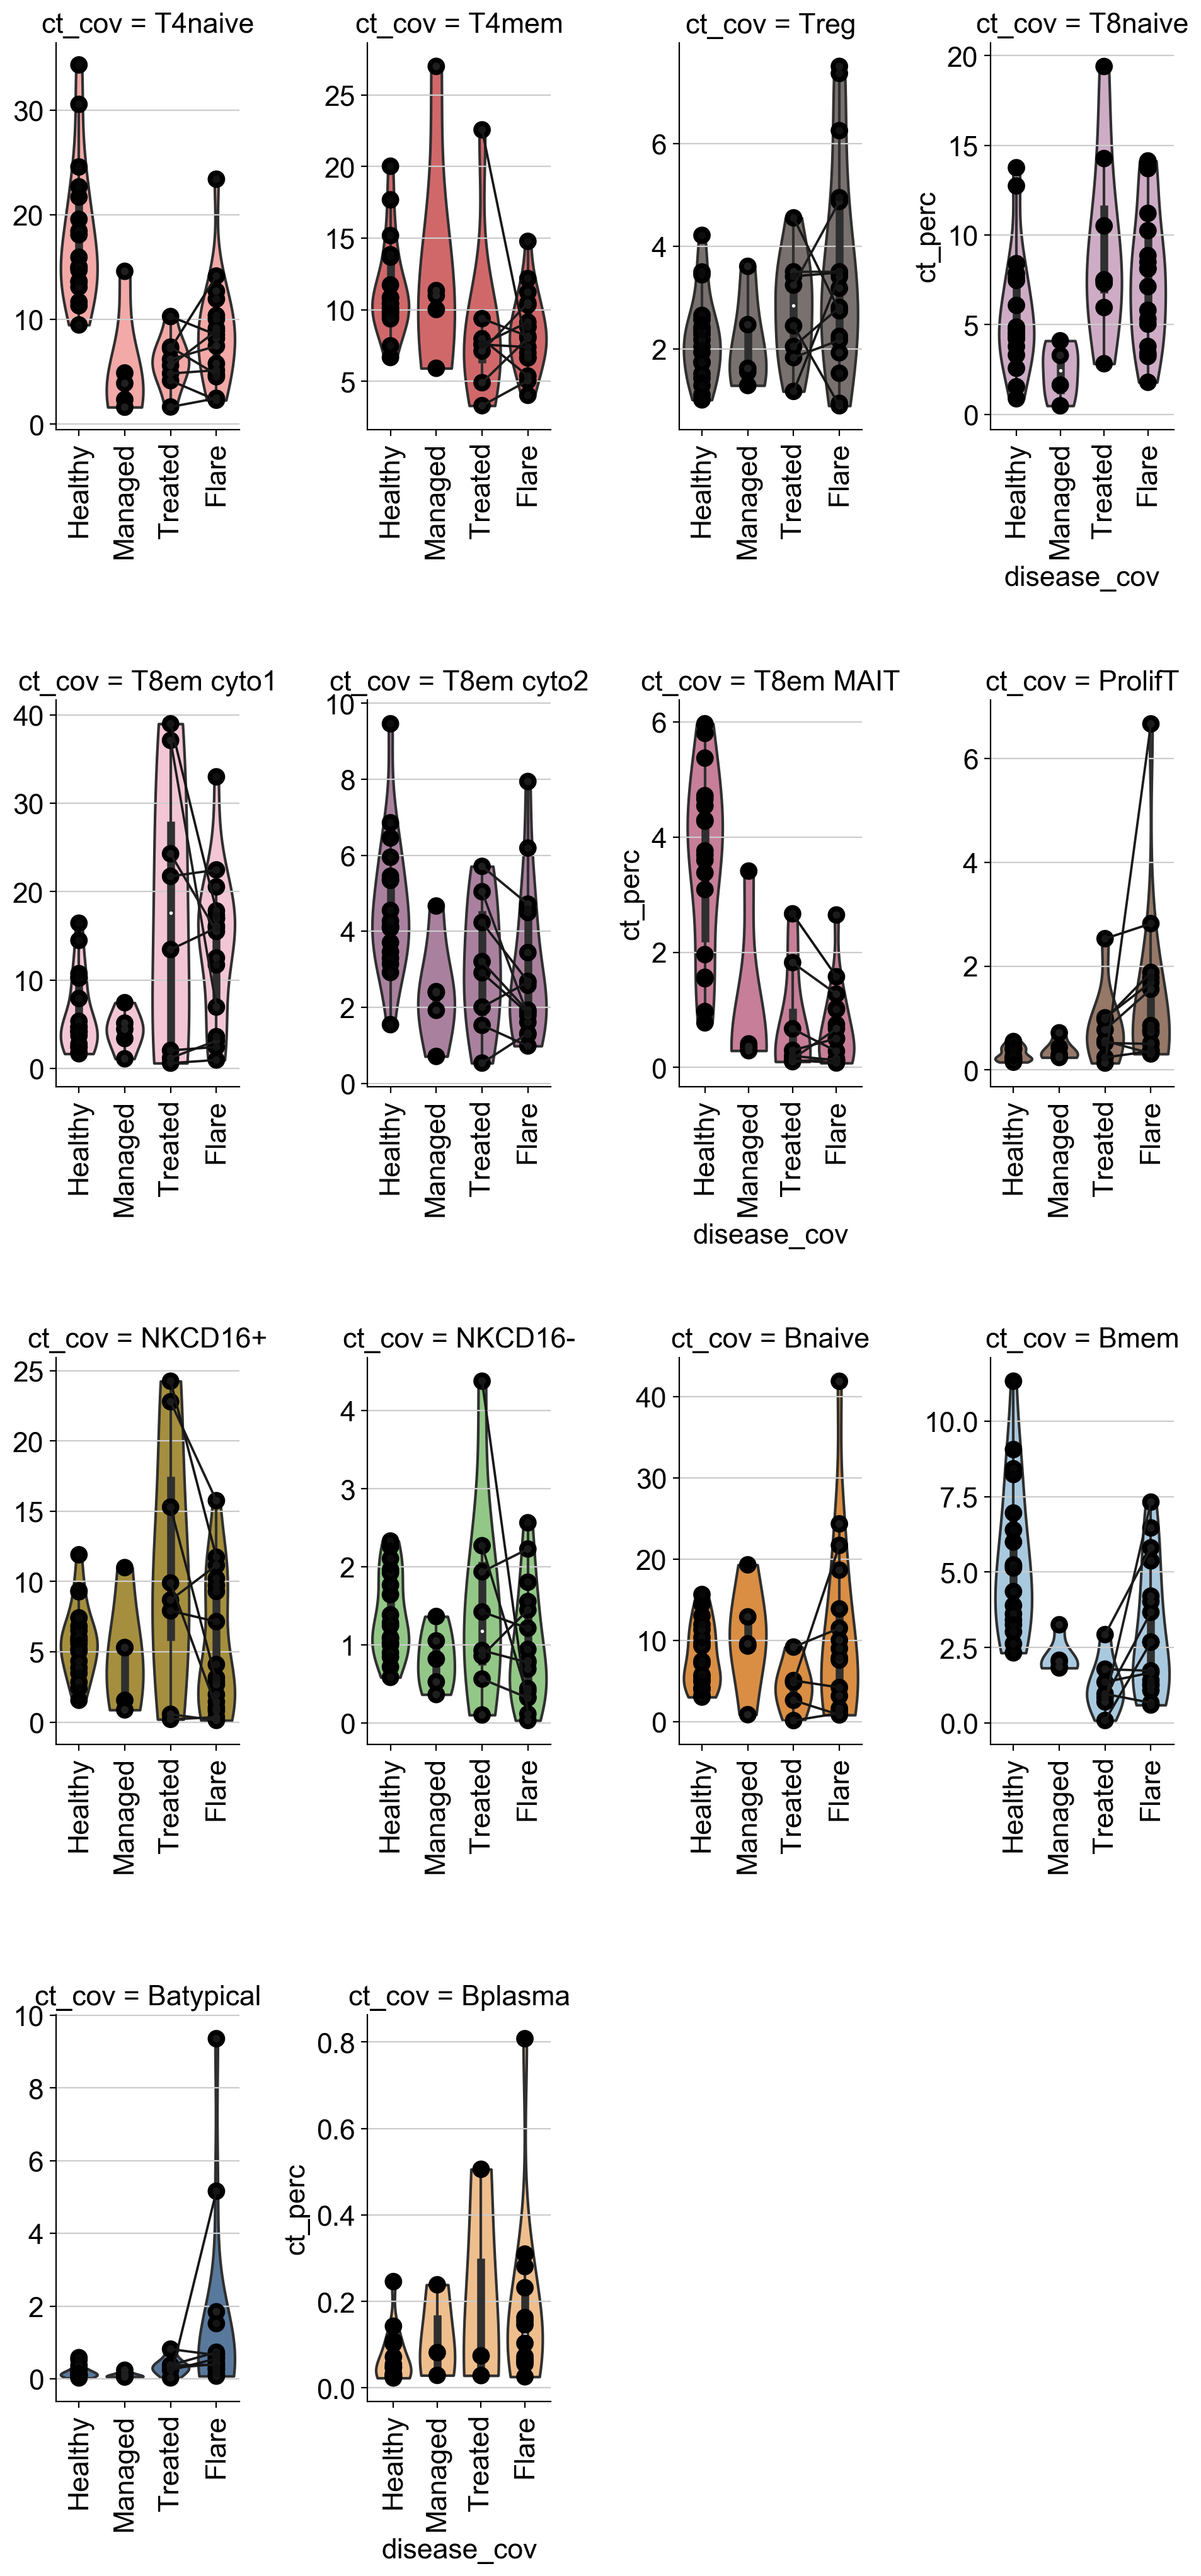

In [29]:
ORDER = ['T4naive', 'T4mem', 'Treg', 'T8naive', 'T8em cyto1', 'T8em cyto2', 'T8em MAIT', 'ProlifT', 'NKCD16+', 'NKCD16-', 'Bnaive', 'Bmem', 'Batypical', 'Bplasma',
        ]

perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov', data=ind_perc, kind='violin', order=[ "Healthy", "Managed", "Treated", "Flare"], col_order=ORDER, col='ct_cov', col_wrap=4, cut=0, dodge=False, aspect=0.5, sharex=False, sharey=False, palette=colorrs)
for ct_i in list(range(len(ORDER))):
    ct = ORDER[ct_i]    
    sns.stripplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color="0",order=[ "Healthy", "Managed", "Treated", "Flare"], size=10, ax=perc_plot.axes[ct_i], jitter=False)
    try:
        sns.pointplot(x="disease_cov", y="ct_perc", hue="ind_cov", data=ind_perc[ind_perc.ct_cov == ct], color="0",order=[ "Healthy", "Managed", "Treated", "Flare"], scale=0.5, ax=perc_plot.axes[ct_i])
    except:
        continue
    perc_plot.axes[ct_i].get_yaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_xaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_legend().remove()
    perc_plot.set_xticklabels(rotation=90)
    perc_plot.fig.subplots_adjust(wspace=0.7, hspace = 0.7)
    
perc_plot.savefig(figdir+"/violin_figure6dlymphct.png")


# Monocytes

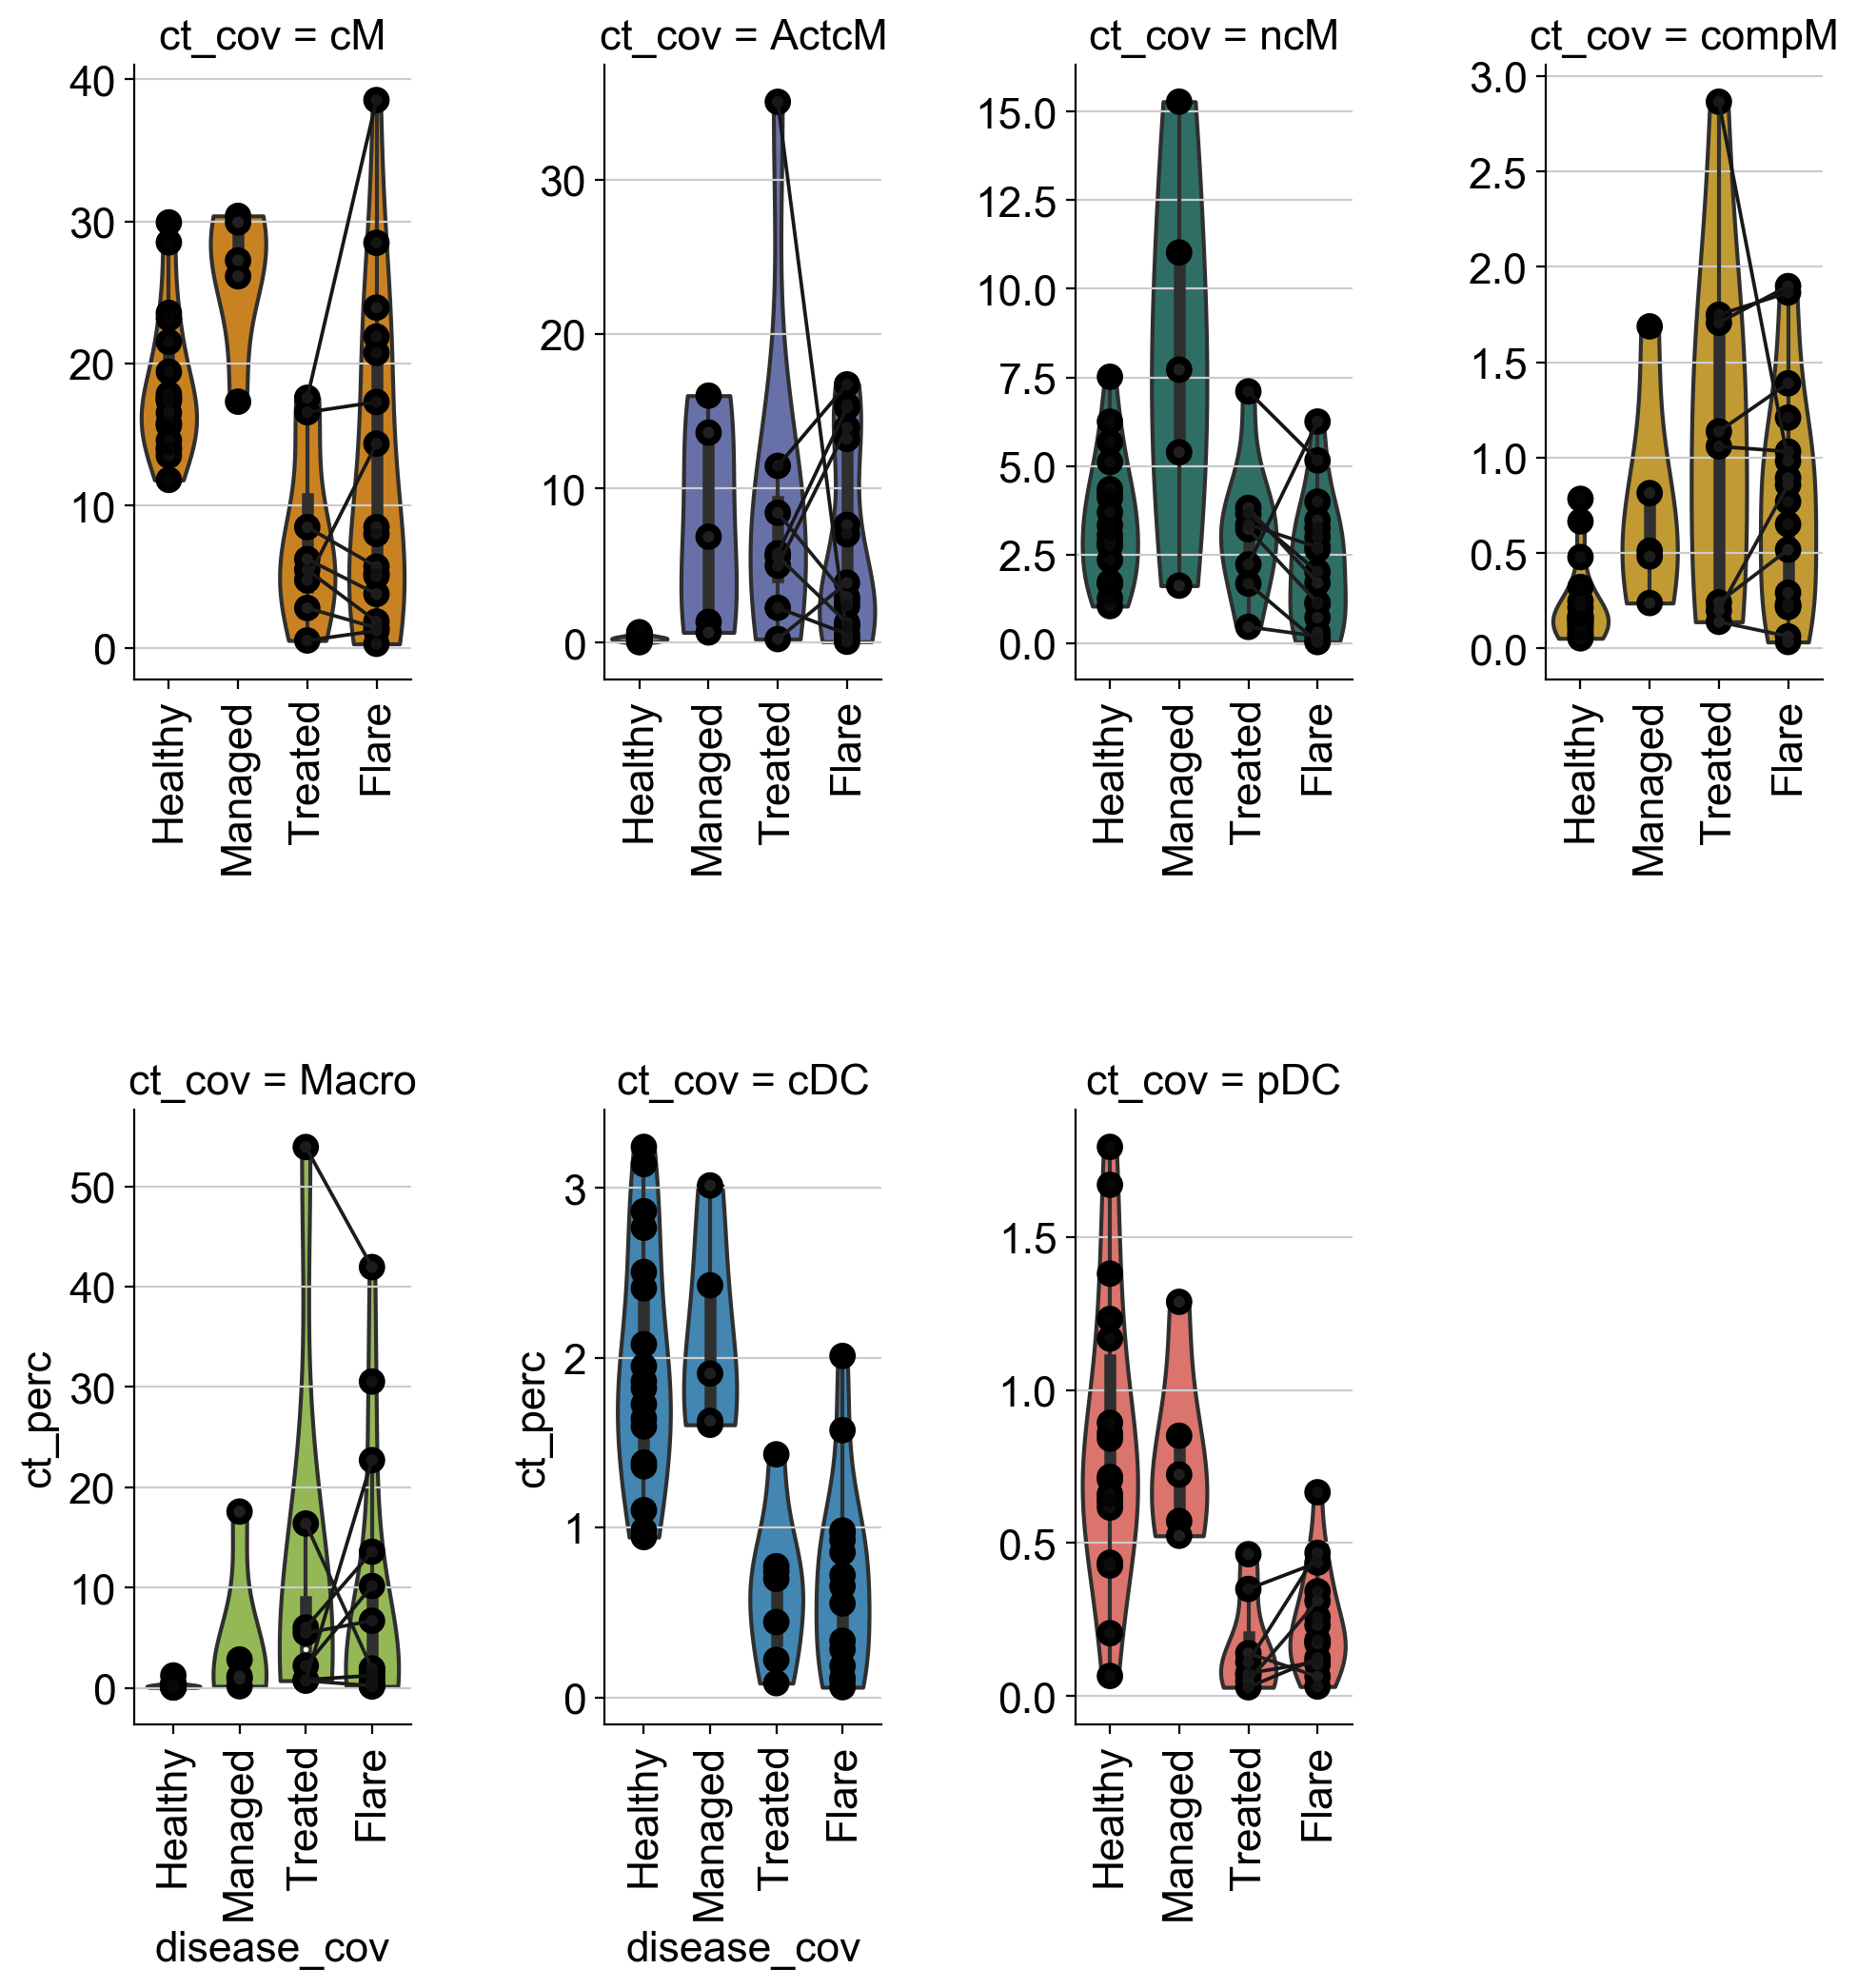

In [30]:
ORDER = ['cM','ActcM','ncM', 'compM', 'Macro', 'cDC', 'pDC'
        ]
perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov', data=ind_perc, kind='violin',order=[ "Healthy", "Managed", "Treated", "Flare"], col_order=ORDER, col='ct_cov', col_wrap=4, cut=0, dodge=False, aspect=0.5, sharex=False, sharey=False, palette=colorrs)

for ct_i in list(range(len(ORDER))):
    ct = ORDER[ct_i]
    sns.stripplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color="0",order=[ "Healthy", "Managed", "Treated", "Flare"], size=10, ax=perc_plot.axes[ct_i], jitter=False)
    try:
        sns.pointplot(x="disease_cov", y="ct_perc", hue="ind_cov", data=ind_perc[ind_perc.ct_cov == ct], color="0",order=[ "Healthy", "Managed", "Treated", "Flare"], scale=0.5, ax=perc_plot.axes[ct_i])
    except:
        continue
    perc_plot.axes[ct_i].get_yaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_xaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_legend().remove()
    perc_plot.set_xticklabels(rotation=90)
    perc_plot.fig.subplots_adjust(wspace=0.7, hspace = 0.7)
   
perc_plot.savefig(figdir+"/violin_figure6dmonoct.png")

# Other Cell Types

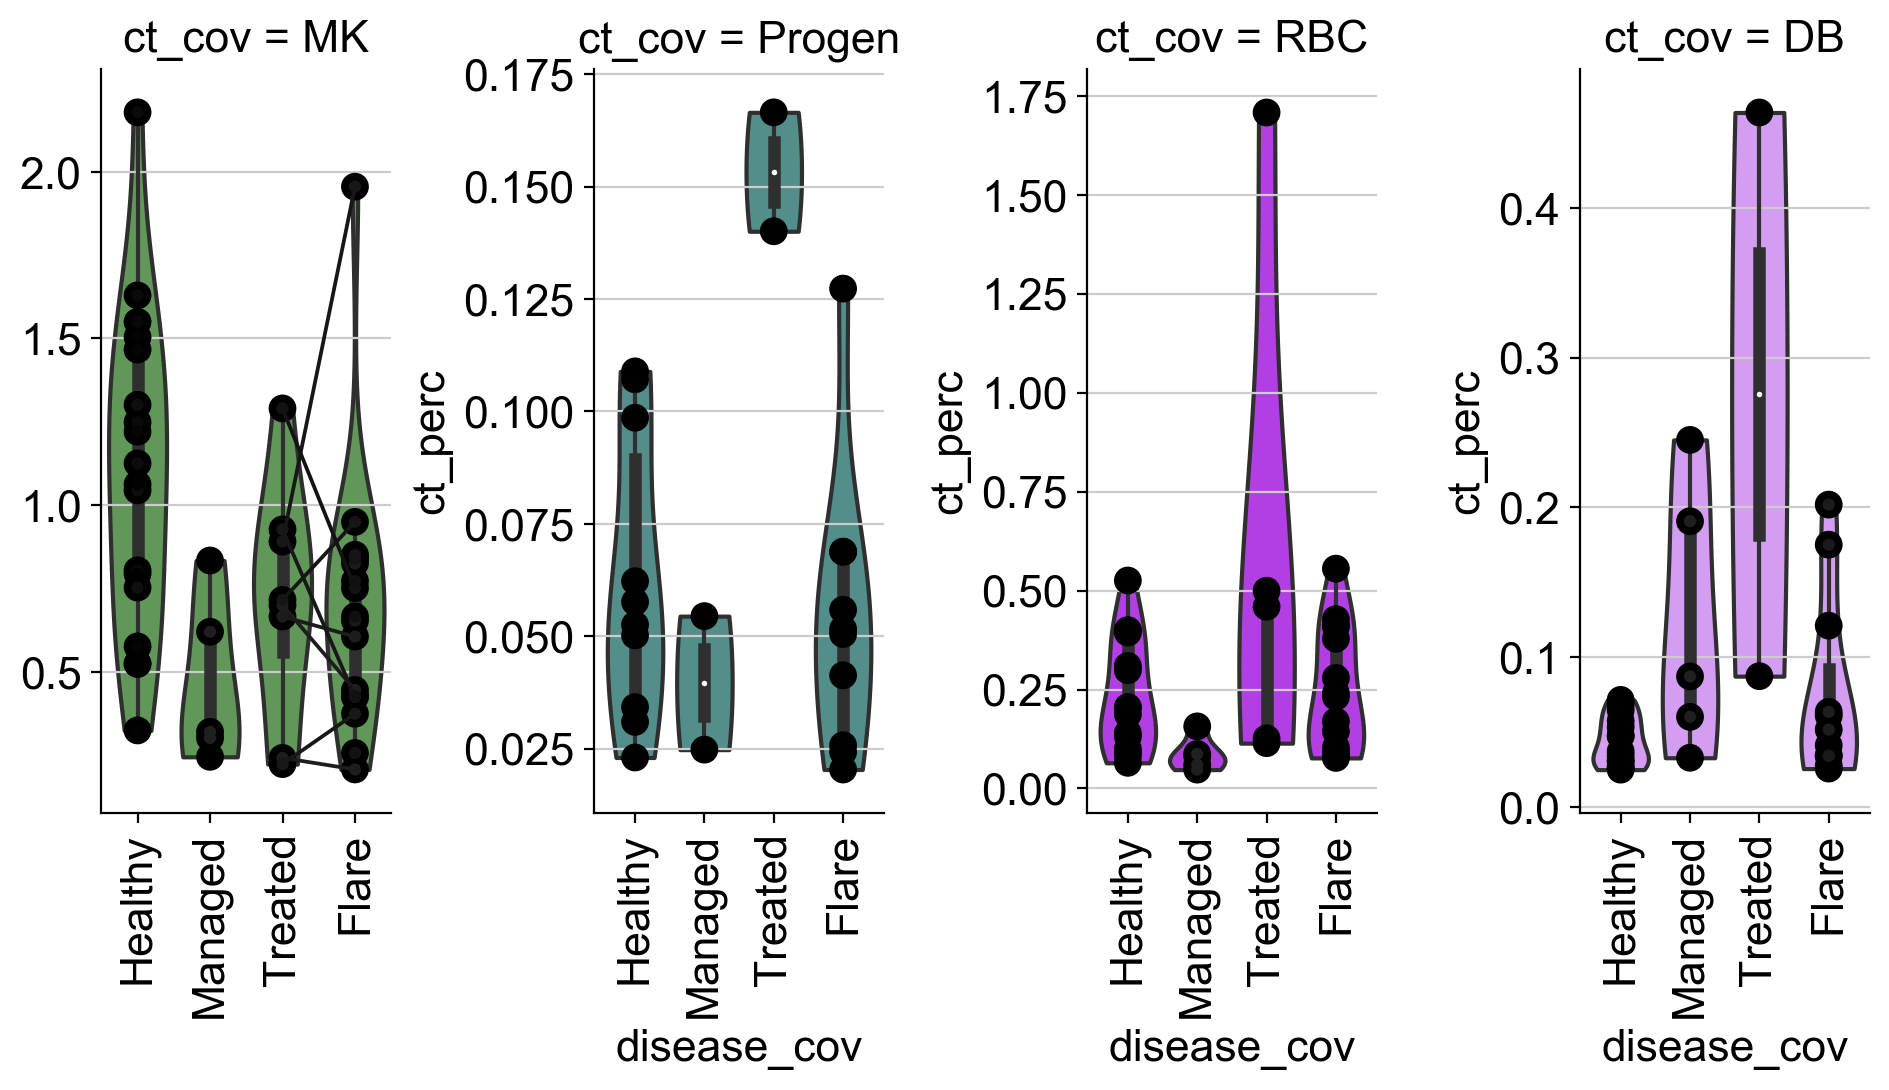

In [31]:
ORDER = ['MK', 'Progen', 'RBC', 'DB'
        ]
perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov', data=ind_perc, kind='violin',order=[ "Healthy", "Managed", "Treated", "Flare"], col_order=ORDER, col='ct_cov', col_wrap=7, cut=0, dodge=False, aspect=0.5, sharex=False, sharey=False, palette=colorrs)
for ct_i in list(range(len(ORDER))):
    ct = ORDER[ct_i]
    sns.stripplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color="0",order=[ "Healthy", "Managed", "Treated", "Flare"], size=10, ax=perc_plot.axes[ct_i], jitter=False)
    try:
        sns.pointplot(x="disease_cov", y="ct_perc", hue="ind_cov", data=ind_perc[ind_perc.ct_cov == ct], color="0",order=[ "Healthy", "Managed", "Treated", "Flare"], scale=0.5, ax=perc_plot.axes[ct_i])
    except:
        continue
    perc_plot.axes[ct_i].get_yaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_xaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_legend().remove()
    perc_plot.set_xticklabels(rotation=90)
    perc_plot.fig.subplots_adjust(wspace=0.7, hspace = 0.7)
    
perc_plot.savefig(figdir+"/violin_figure6dotherct.png")

# Effect size scatter plot

In [32]:
MasterORDER = ['Batypical', 'Bmem', 'Bnaive', 'Bplasma', 'MK', 'NKCD16-', 'NKCD16+', 'Progen', 'T4mem', 'T4naive', 'Treg', 'T8em MAIT', 'T8em cyto1', 'T8em cyto2', 
               'T8naive', 'ProlifT', 'cM', 'ActcM', 'ncM', 'compM', 'Macro', 'pDC', 'cDC']
colorrs = ["#4E79A7","#A0CBE8","#F28E2B","#FFBE7D","#59A14F","#8CD17D","#B6992D","#499894","#E15759","#FF9D9A","#79706E","#D37295","#FABFD2","#B07AA1","#D4A6C8","#9D7660",
                 "#E58606", "#5D69B1", "#24796C", '#DAA51B', '#99C945', '#ED645A', '#2F8AC4']

# Generate dictionary containing values from cross-sectional dataset.
CROSSTRHEALTHY = {'Batypical':-0.04660550052009935, 'Bmem':2.5848954276333918, 'Bnaive':-2.791721747149453, 'Bplasma':-0.026582802352059197, 'MK':0.5504103573271134,'NKCD16-':0.04321027880173084, 'NKCD16+':0.12446914833438122,
                 'Progen':0.4385938985860165, 'T4mem':-2.085932090715172, 'T4naive':12.65177804972718, 'Treg':0.011720374567987996, 'T8em MAIT':2.124190130207837, 'T8em cyto1':-4.569644610540978, 'T8em cyto2':-1.1550718185509596,
                 'T8naive':3.4865647863078855, 'ProlifT':-0.20821975040448304, 'cM':-2.359728159036588, 'ActcM':-5.756097081131859, 'ncM':-2.1640225205030905, 'compM':-0.29015548287165194, 'Macro':-0.054227405885961324, 'pDC':0.5457223411567755, 'cDC':0.13125795717366492}
Comparison_plot_data = pd.DataFrame({'UNT/HEALTHY':pd.Series(HEALTHYFLARE_effect), 'Cross_TR/HEALTHY':pd.Series(CROSSTRHEALTHY)})
Comparison_plot_data = Comparison_plot_data.reindex(MasterORDER)
Comparison_plot_data = Comparison_plot_data.dropna()
Comparison_plot_data['Cell Type'] = Comparison_plot_data.index
Comparison_plot_data['UNT/HEALTHY'] = Comparison_plot_data['UNT/HEALTHY'].abs()
Comparison_plot_data['Cross_TR/HEALTHY'] = Comparison_plot_data['Cross_TR/HEALTHY'].abs()
display(Comparison_plot_data)
ax = sns.scatterplot(x="UNT/HEALTHY", y="Cross_TR/HEALTHY", hue='Cell Type', data=Comparison_plot_data, s=100, marker="o", palette=colorrs)
line = np.linspace(0.001, 20, 10)
ax = plt.plot(line, line, color='k')
ax = plt.axis('equal')
ax = plt.xlabel('Beta Flare/Healthy')
ax = plt.ylabel('Beta Cross-Sectional Treated/Healthy')
ax = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax = plt.yscale('log')
ax = plt.xscale('log')
ax = plt.savefig(figdir+'/Flare-Healthy_Effect_size_scatterplot_subpops.pdf')
ax = plt.savefig(figdir+'/Flare-Healthy_Effect_size_scatterplot_subpops.png')
print(Comparison_plot_data.corr(method='pearson'))


UNT/HEALTHY  Cross_TR/HEALTHY   Cell Type
Batypical      1.298763          0.046606   Batypical
Bmem           2.147079          2.584895        Bmem
Bnaive         1.794823          2.791722      Bnaive
Bplasma        0.088755          0.026583     Bplasma
MK             0.504237          0.550410          MK
NKCD16-        0.378184          0.043210     NKCD16-
NKCD16+        0.070658          0.124469     NKCD16+
Progen         0.015301          0.438594      Progen
T4mem          2.696009          2.085932       T4mem
T4naive       10.175330         12.651778     T4naive
Treg           1.431433          0.011720        Treg
T8em MAIT      2.585512          2.124190   T8em MAIT
T8em cyto1     9.404919          4.569645  T8em cyto1
T8em cyto2     1.243759          1.155072  T8em cyto2
T8naive        2.581445          3.486565     T8naive
ProlifT        0.859051          0.208220     ProlifT
cM             6.193702          2.359728          cM
ActcM          5.210501          5.756097       ActcM
ncM            1.205182          2.164023         ncM
compM          0.562545          0.290155       compM
Macro          5.631902          0.054227       Macro
pDC            0.530743          0.545722         pDC
cDC            1.141736          0.131258         cDC

ValueError: math domain error

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f9a41543f80> (for post_execute):


ValueError: math domain error

ValueError: math domain error

<Figure size 400x400 with 1 Axes>

# Cell type correlations with cross-sectional data

In [33]:
# Load cross-sectional lymph data
lymph = pd.read_csv('../figure4_lymphoid/lymph_expr_ct_cov.csv')
lymph.rename(columns={'Unnamed: 0':'Gene'}, inplace=True)
lymph = lymph.set_index('Gene')
del lymph.index.name
# lymph data genes
lymphgenes = lymph.index.tolist()
# Intersection of genes for lymph
flaredata = adata[:, adata.var_names.isin(lymphgenes)]
marker_dictionary = pd.DataFrame({"all": flaredata.var_names})
flarelymph = marker_gene_expression(flaredata, marker_dictionary, partition_key="leiden")
lymphresult = pd.concat([lymph, flarelymph], axis=1, join='inner')

mono = pd.read_csv('../figure3_myeloid/myeloid_expr_ct_cov.csv')
mono.rename(columns={'Unnamed: 0':'Gene'}, inplace=True)
mono = mono.set_index('Gene')
del mono.index.name
# mono data genes
monogenes = mono.index.tolist()
# Intersection of genes for mono
flaredata = adata[:, adata.var_names.isin(monogenes)]
marker_dictionary = pd.DataFrame({"all": flaredata.var_names})
flaremono = marker_gene_expression(flaredata, marker_dictionary, partition_key="leiden")
monoresult = pd.concat([mono, flaremono], axis=1, join='inner')



FileNotFoundError: [Errno 2] File b'../figure4_lymphoid/lymph_expr_ct_cov.csv' does not exist: b'../figure4_lymphoid/lymph_expr_ct_cov.csv'

In [ ]:
print('Lymphocyte')
lymphcorr = lymphresult.corr()
lymphcorr.to_csv('Lymphocyte_CrossX_Flare_Correlations.csv')
lymphcorr.style.background_gradient(cmap='coolwarm').set_precision(2)
import seaborn as sns; sns.set(color_codes=True); sns.set(font_scale=0.75)
g = sns.clustermap(lymphcorr, yticklabels=True, xticklabels=True)
g.savefig("Lymphocyte_CrossX_Flare_Correlations.png")

In [ ]:
print('Myeloid')
monocorr = monoresult.corr()
monocorr.to_csv('Myeloid_CrossX_Flare_Correlations.csv')
monocorr.style.background_gradient(cmap='coolwarm').set_precision(2)
import seaborn as sns; sns.set(color_codes=True); sns.set(font_scale=0.75)
g = sns.clustermap(monocorr, yticklabels=True, xticklabels=True)
g.savefig("Myeloid_CrossX_Flare_Correlations.png")

In [ ]:
adata.obs['ct_cov_Flr'] = adata.obs['ct_cov'].astype('object')
# # ## do some manual cell type assignment
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "0"] = "Bnaive_Flare" ## good                                                                                    
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "1"] = "NKCD16+_Flare" ## good                                                                                    
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "2"] = "T8em cyto1_Flare" ## good                                                                                     
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "3"] = "T8naive_Flare" ## good                                                                                    
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "4"] = "T4naive_Flare" ## good                                                                                    
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "5"] = "cM_Flare" ## good                                                                                    
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "6"] = "T4mem_Flare" ## good                                                                                    
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "7"] = "T4naive_Flare" ## good                                                                                    
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "8"] = "cM_Flare" ## good                                                                                    
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "9"] = "ActcM_Flare" ## good                                                                                    
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "10"] = "cM_Flare" ## good                                                                                  
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "11"] = "ncM_Flare" ## good                                                                                    
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "12"] = "Macro_Flare" ## good                                                                                   
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "13"] = "T8em cyto2_Flare" ## good                                                                                   
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "14"] = "T8em cyto1_Flare" ## good                                                                                  
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "15"] = "T4mem_Flare" ## good                                                                                   
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "16"] = "Bmem_Flare" ## good                                                                                   
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "17"] = "T4naive_Flare" ## good                                                                                  
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "18"] = "cM_Flare" ## good                                                                              
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "19"] = "Treg_Flare" ## good                                                                               
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "20"] = "T8em MAIT_Flare" ## good                                                                                   
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "21"] = "T4mem_Flare" ##
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "22"] = "cDC_Flare" ##
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "23"] = "NKCD16-_Flare" ##
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "24"] = "MK_Flare" ##
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "25"] = "ProlifT_Flare" ##
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "26"] = "T4mem_Flare" ##
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "27"] = "compM_Flare" ##
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "28"] = "Batypical_Flare" ##
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "29"] = "pDC_Flare" ##
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "30"] = "T4naive_Flare" ##
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "31"] = "RBC_Flare" ##
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "32"] = "T4mem_Flare" ##
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "33"] = "Bplasma_Flare" ##
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "34"] = "NKCD16-_Flare" ##
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "35"] = "DB_Flare" ##
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "36"] = "Bnaive_Flare" ##
adata.obs['ct_cov_Flr'].loc[adata.obs.leiden == "37"] = "Progen_Flare" ##
adata.obs['ct_cov_Flr'] = adata.obs['ct_cov_Flr'].astype('category')

catORDER = ['cM_Flare', 'ncM_Flare', 'ActcM_Flare', 'compM_Flare', 'Macro_Flare', 'cDC_Flare', 'pDC_Flare', 'Batypical_Flare', 'Bmem_Flare', 'Bnaive_Flare',
                                                                 'Bplasma_Flare', 'MK_Flare', 'NKCD16+_Flare', 'NKCD16-_Flare', 'Progen_Flare', 'T4mem_Flare', 'T4naive_Flare', 'Treg_Flare', 'T8em cyto1_Flare', 'T8em cyto2_Flare', 'T8em MAIT_Flare', 
                                                                 'T8naive_Flare', 'ProlifT_Flare', 'DB_Flare', 'RBC_Flare']
adata.obs['ct_cov_Flr'] = adata.obs['ct_cov_Flr'].cat.reorder_categories(catORDER)


# Load cross-sectional lymph data
lymph = pd.read_csv('../figure4_lymphoid/lymph_expr_ct_cov.csv')
lymph.rename(columns={'Unnamed: 0':'Gene'}, inplace=True)
lymph = lymph.set_index('Gene')
del lymph.index.name
mono = pd.read_csv('../figure3_myeloid/myeloid_expr_ct_cov.csv')
mono.rename(columns={'Unnamed: 0':'Gene'}, inplace=True)
mono = mono.set_index('Gene')
del mono.index.name

marker_dictionary = pd.DataFrame({"all": adata.var_names})
flare = marker_gene_expression(adata, marker_dictionary, partition_key="ct_cov_Flr")
flare = flare.drop(labels=['DB_Flare', 'RBC_Flare'], axis=1)
corrresult = pd.concat([mono, lymph, flare], axis=1, join='inner')

crossX_Flarecorr = corrresult.corr()
# Remove duplicate labels from column (the diagnal of correlation plot)
crossX_Flarecorr = crossX_Flarecorr.drop(columns=catORDER[:-2])
# Remove columns headers from row
crossX_Flarecorr = crossX_Flarecorr.drop(labels=list(crossX_Flarecorr.columns.values))
crossX_Flarecorr.to_csv('CrossX_Flare_Correlations.csv')
crossX_Flarecorr.style.background_gradient(cmap='coolwarm').set_precision(2)
import seaborn as sns; sns.set(color_codes=True); sns.set(font_scale=0.75)
g = sns.clustermap(crossX_Flarecorr, yticklabels=True, xticklabels=True, col_cluster=False, row_cluster=False)
g.savefig(figdir+"/CrossX_Flare_pop_Correlations.png")


# Map colors onto cell type labels

In [ ]:
colormapping = dict()
unique_ct = adata.obs.ct_cov.cat.categories.tolist()
for ii in range(len(unique_ct)):
    colormapping[unique_ct[ii]] = adata.uns['ct_cov_colors'][ii]

In [ ]:
'''
version = '/ye/yelabstore3/Richard/PlottingScripts/ez_scanpy/V6/CLUESImmVar_processed.V6.4.11.2019.annotated.h5ad'
adata = sc.read(version)
print(adata)
cdata = adata[adata.obs['ind_cov'].isin(['1340_1340', '900759200_900759200', '901347200_901347200'])]
B_treated = [0.025517, 0.054765, 27.407201]
B_treated = [1, 2, 982]
'''

In [ ]:
# Atypical memory B cells
sc.pl.umap(adata, color=['CR2', 'CD27', 'FCRL5', 'ITGAX', 'NKG7'],show=False, save='_AtypicalBgenes.png')

In [ ]:
# Macro
sc.pl.umap(adata, color='CD163', size=3, show=False, edgecolor="none", save='_CD163_expression.png')

In [ ]:
ddata = adata[adata.obs['ct_cov']=='ProlifT']
sc.pl.violin(ddata,keys=['CD8A', 'CD3D'], groupby='disease_cov',show=False, save='_Tprolif_CD8A.png')


In [ ]:
sc.pl.umap(adata, color=['CD4', 'CD8A'], save='_ruleoutDoublePositive.png')


In [ ]:
## platelet effect
sc.pl.umap(adata, color=["PF4", "SDPR", "GNG11", "PPBP"], size=3, save='_platelet.png')

In [ ]:
## cycling
sc.pl.umap(adata, color=["KIAA0101","STMN1","TK1","MKI67"], size=3, save='_cycling.png')

In [ ]:
## MACROPHAGES
sc.pl.umap(adata, color=['CD163', 'HLA-DRB1', 'C1QA', 'IFITM3'], size=3, show=False, save="_MACRO.png")

In [ ]:
## CD4, CD8 and NK axis
sc.pl.umap(adata, color=["CD3D","CD8A","CD4","NCAM1", "FCGR3A", 'NKG7', 'IFNG', 'GZMB', 'PRF1'],size=3, show=False, save="_TNK.png")
# Two NK sub populations: CD56high/lowCD16high/low, CD56lowCD16high
# https://www.frontiersin.org/files/Articles/162361/fimmu-06-00567-HTML/image_m/fimmu-06-00567-g001.jpg

In [ ]:
#sc.pl.violin(adata, keys= ['GZMB', 'PRF1', 'SH2D1A', 'ICAM1','CD86', 'RAB27A', 'UNC13D', 'FHL3', 'FHL2'], groupby='disease_cov', show=False, use_raw=False, save='.T8emcyto1expression')
#sc.pl.stacked_violin(adata, keys= ['GZMB', 'PRF1', 'SH2D1A', 'ICAM1','CD86', 'RAB27A', 'UNC13D', 'FHL3', 'FHL2'], groupby='disease_cov', show=False, use_raw=False, save='.T8emcyto1expression')
sc.pl.umap(adata, color=['GZMB', 'PRF1', 'SH2D1A', 'ICAM1','CD86', 'RAB27A', 'UNC13D', 'FHL3', 'FHL2'],size=3, show=False, use_raw=True, save="_gzmbgenes.png")
sc.pl.violin(adata, keys= ['GZMB', 'PRF1', 'SH2D1A', 'ICAM1','CD86', 'RAB27A', 'UNC13D', 'FHL3', 'FHL2'], groupby='disease_cov', show=False, use_raw=True, save='_T8emcyto1expression_raw.png')
#sc.pl.stacked_violin(adata, var_names= ['GZMB', 'PRF1', 'SH2D1A', 'ICAM1','CD86', 'RAB27A', 'UNC13D', 'FHL3', 'FHL2'], groupby='disease_cov', show=False, use_raw=True, save='.T8emcyto1expression_raw')


In [ ]:
## Memory vs. helper vs. naive
sc.pl.umap(adata, color=["CCR7","IL7R","S100A4","CD58", 'FAS', 'IL2RA'],show=False, size=3, save="_TMemThTNaive.png")

In [ ]:
## treg
sc.pl.umap(adata, color=["FOXP3","TNFRSF4","ENTPD1","CCR10"],size=3, save="_TREG.png")

In [ ]:
## y chromosome gender effect
sc.pl.umap(adata, color=["DDX3Y", "RPS4Y1", "FHIT","TRAT1"], size =3, save="_Y.png")

In [ ]:
## b cells, plasmablasts and pdcs
sc.pl.umap(adata, color=["MZB1", "IGJ", "CD79A", 'CD27', 'FCRL5', 'IL6', 'FCRLA', 'FCRL3'],size=3, save="_B.png")

# Lymphocyte and Monocyte proportions

In [ ]:
## Make proportion plots
adata_obs_small = adata.obs
## no batch_cov so that we aggregate the count for the two healthy controls
ind_count = adata_obs_small.groupby(['ind_cov_disease_cov','ct_group','disease_cov', 'ind_cov'])['ct_group'].count()
ind_count_sums = ind_count.groupby(level=[0]).sum()
ind_count_sums = ind_count_sums.reset_index(name="counts")
ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc")
## filter samples that have < 100 cells
ind_perc = ind_perc[ind_perc.ind_cov_disease_cov.isin(ind_count_sums.ind_cov_disease_cov[ind_count_sums.counts > 100])]

ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_count_sums.ind_cov_disease_cov = ind_count_sums.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_perc = ind_perc.set_index('ct_group')
ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.astype("str")
ind_perc.reset_index(inplace=True)
ind_perc.ct_group = ind_perc.ct_group.astype('category')
# Reorder categories for plotting
ORDER = ['lymph', 'mono', 'MK', 'Progen', 'RBC', 'Doublet']
perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_group', col_order=ORDER,order=[ "Healthy", "Managed", "Treated", "Flare"], data=ind_perc, kind='violin', col='ct_group', cut=0, dodge=False, aspect=0.75, sharex=False, sharey=False)

for ct_i in list(range(len(ORDER))) :
    ct = ORDER[ct_i]
    sns.stripplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_group == ct], color="0",order=[ "Healthy", "Managed", "Treated", "Flare"], size=10, ax=perc_plot.axes[0, ct_i], jitter=False)
    try:
        sns.pointplot(x="disease_cov", y="ct_perc", hue="ind_cov", data=ind_perc[ind_perc.ct_group == ct], color="0",order=[ "Healthy", "Managed", "Treated", "Flare"], scale=0.5, ax=perc_plot.axes[0,ct_i])
    except:
        continue
    perc_plot.axes[0, ct_i].get_yaxis().label.set_visible(False)
    perc_plot.axes[0, ct_i].get_xaxis().label.set_visible(False)
    perc_plot.axes[0, ct_i].get_legend().remove()
    perc_plot.set_xticklabels(rotation=90)
    perc_plot.fig.subplots_adjust(wspace=0.7, hspace = 0.7)
    
perc_plot.savefig(figdir+"/violin_ct_group.png")
sc.pl.umap(adata, color='ct_group', show=True, size=3, save='.ct_group', edgecolor="none", palette=sc.pl.palettes.vega_20_scanpy)

# Protein analysis

In [34]:
adata.obs['ct_cov_11'] = adata.obs['batch_cov'].astype("str")
# # ## do some manual cell type assignment
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "0"] = "B" ## good                                                                                    
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "1"] = "NK" ## good                                                                                    
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "2"] = "T8" ## good                                                                                     
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "3"] = "T8" ## good                                                                                    
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "4"] = "T4" ## good                                                                                    
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "5"] = "cM" ## good                                                                                    
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "6"] = "T4" ## good                                                                                    
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "7"] = "T4" ## good                                                                                    
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "8"] = "cM" ## good                                                                                    
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "9"] = "cM" ## good                                                                                    
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "10"] = "cM" ## good                                                                                  
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "11"] = "ncM" ## good                                                                                    
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "12"] = "cM" ## good                                                                                   
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "13"] = "T8" ## good                                                                                   
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "14"] = "T8" ## good                                                                                  
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "15"] = "T4" ## good                                                                                   
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "16"] = "B" ## good                                                                                   
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "17"] = "T4" ## good                                                                                  
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "18"] = "cM" ## good                                                                              
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "19"] = "T4" ## good                                                                               
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "20"] = "T8" ## good                                                                                   
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "21"] = "T4" ##
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "22"] = "cDC" ##
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "23"] = "NK" ##
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "24"] = "MK" ##
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "25"] = "ProlifT" ##
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "26"] = "T4" ##
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "27"] = "ncM" ##
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "28"] = "B" ##
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "29"] = "pDC" ##
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "30"] = "T4" ##
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "31"] = "RBC" ##
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "32"] = "T4" ##
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "33"] = "B" ##
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "34"] = "NK" ##
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "35"] = "DB" ##
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "36"] = "B" ##
adata.obs['ct_cov_11'].loc[adata.obs.leiden == "37"] = "Progen" ##
adata.obs['ct_cov_11'] = adata.obs.ct_cov_11.astype('category')


In [35]:
pdata = adata.copy()
print(pdata)

AnnData object with n_obs × n_vars = 153955 × 1164 
    obs: 'SOURCE', 'batch_cov', 'ind_cov', 'well', 'Female', 'pop_cov', 'Broad', 'CD38|CD38|j95-01|pAbO', 'CD95|FAS|j95-02|pAbO', 'CD28|CD28|j95-07|pAbO', 'CD27|CD27|j95-08|pAbO', 'CD197|CCR7|j95-09|pAbO', 'CD19|CD19|j95-10|pAbO', 'CD161|KLRB1|j95-11|pAbO', 'CD183|CXCR3|j95-12|pAbO', 'CD4|CD4|j95-14|pAbO', 'CD3|CD3E|j95-16|pAbO', 'CD196|CCR6|j95-17|pAbO', 'HLA-DR|CD74|j95-18|pAbO', 'CD45RO|PTPRC|j95-19|pAbO', 'CD14|CD14|j95-20|pAbO', 'CD194|CCR4|j95-21|pAbO', 'CD185|CXCR5|j95-22|pAbO', 'CD25|IL2RA|j95-24|pAbO', 'CD8|CD8A|j95-25|pAbO', 'CD127|IL7R|j95-27|pAbO', 'CD45RA|PTPRC|j95-28|pAbO', 'disease_cov', 'percent_mito', 'n_counts', 'n_genes', 'PF4', 'SDPR', 'GNG11', 'PPBP', 'PC3', 'PC16', 'steroid', 'plaquenil', 'cellcept', 'cyclophosphamide', 'rituxumab', 'louvain', 'leiden', 'site', 'disease_pop_site_cov', 'ind_cov_disease_cov', 'umap_density_disease_cov', '_tmp_embedding_density_column_5886_', 'ct_cov', 'ct_group', 'ct_cov_11'
    un

In [48]:
import anndata as ad
##import combat2
##import combat
import patsy
# Find antibodies
ab_names = [ab for ab in pdata.obs_keys() if 'pAbO' in ab]
print(ab_names)
obs = pd.DataFrame()
obs['disease_cov'] = pdata.obs['disease_cov']
pdata.obs['batch_cov'] = pdata.obs['batch_cov'].astype('str')
obs['batch_cov'] = pdata.obs['batch_cov']
obs['well'] = pdata.obs['well']
obs['Female'] = pdata.obs['Female']
obs['ct_cov_rna'] = pdata.obs['ct_cov']
obs['ct_cov_rna_11'] = pdata.obs['ct_cov_11']
var = pd.DataFrame(index=ab_names)
pdatapseudo = ad.AnnData(pdata.obs[ab_names].values, obs=obs, var=var, dtype='float64')
print(pdatapseudo)

# Add the total counts per cell as observations-annotation to pdatapseudo
pdatapseudo.obs['n_counts'] = np.ravel(pdatapseudo.X.sum(axis=1))
print('Normalizing total counts to 10,000')
sc.pp.normalize_per_cell(pdatapseudo, counts_per_cell_after=1e4)
print('Log transforming data')
sc.pp.log1p(pdatapseudo)
print('Making .obs into categories')
pdatapseudo.strings_to_categoricals()
sc.pp.scale(pdatapseudo, max_value=10)
## compute PCA
sc.pp.pca(pdatapseudo, random_state=1, svd_solver='arpack')
regressors = ['n_counts', 'Female'] # Add batch_cov?
print('Regressing out total nUMIs, and gender')
print('regressors: '+str(regressors))
sc.pp.regress_out(pdatapseudo, regressors)
print('Scaling expression data')
sc.pp.scale(pdatapseudo, max_value=10)


## combat adjustment                                                                                                                                                                                                           
print('Running combat')
mod = patsy.dmatrix("~ disease_cov", pdatapseudo.obs, return_type="dataframe")
mod = mod.reset_index(drop=True)
batch = pdatapseudo.obs['well']
batch = batch.reset_index(drop=True)
pdatapseudo.obs["batch"] = batch;
##pdatapseudo.X = combat.combat(pdatapseudo.X.transpose(), batch=batch, model=mod).transpose();
sc.pp.combat(pdatapseudo, key="batch", covariates=["disease_cov"]);


#######################
# Louvain and friends #
#######################
# Set parameters
intialization = 1
n_components = 15
resolution = 0.5
# Run louvain clustering on theoretical future gene expression per cell
logging.info('Estimating louvain cluster identities for gene expression values.')
sc.pp.pca(pdatapseudo ,random_state=intialization, svd_solver='arpack')
logging.info('PCA complete.')
sc.pp.neighbors(pdatapseudo, n_pcs=15, use_rep='X_pca', random_state=intialization)
#sc.pp.neighbors(pdatapseudo, random_state=intialization)
logging.info('KNN complete.')
sc.tl.leiden(pdatapseudo, random_state=intialization, resolution=resolution)
logging.info('Leiden complete.')
sc.tl.umap(pdatapseudo, spread=2, random_state=intialization)
logging.info('UMAP complete.')
logging.info('Making .obs into categories')
pdatapseudo.strings_to_categoricals()
logging.info('Basic analysis complete.')

['CD38|CD38|j95-01|pAbO', 'CD95|FAS|j95-02|pAbO', 'CD28|CD28|j95-07|pAbO', 'CD27|CD27|j95-08|pAbO', 'CD197|CCR7|j95-09|pAbO', 'CD19|CD19|j95-10|pAbO', 'CD161|KLRB1|j95-11|pAbO', 'CD183|CXCR3|j95-12|pAbO', 'CD4|CD4|j95-14|pAbO', 'CD3|CD3E|j95-16|pAbO', 'CD196|CCR6|j95-17|pAbO', 'HLA-DR|CD74|j95-18|pAbO', 'CD45RO|PTPRC|j95-19|pAbO', 'CD14|CD14|j95-20|pAbO', 'CD194|CCR4|j95-21|pAbO', 'CD185|CXCR5|j95-22|pAbO', 'CD25|IL2RA|j95-24|pAbO', 'CD8|CD8A|j95-25|pAbO', 'CD127|IL7R|j95-27|pAbO', 'CD45RA|PTPRC|j95-28|pAbO']
AnnData object with n_obs × n_vars = 153955 × 20 
    obs: 'disease_cov', 'batch_cov', 'well', 'Female', 'ct_cov_rna', 'ct_cov_rna_11'
Normalizing total counts to 10,000
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


... storing 'batch_cov' as categorical


Log transforming data
Making .obs into categories
computing PCA with n_comps = 50
    finished (0:00:00)
Regressing out total nUMIs, and gender
regressors: ['n_counts', 'Female']
regressing out ['n_counts', 'Female']
    finished (0:00:01)
Scaling expression data
Running combat
Standardizing Data across genes.

Found 12 batches

Found 1 categorical variables:
	disease_cov

Found 0 numerical variables:
	



/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:54: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  design = pd.concat((design, factor_matrix), axis=1)
/Users/yimmieg/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:110: RuntimeWarning: invalid value encountered in true_divide
  grand_mean = np.dot((n_batches / n_array).T, B_hat[:n_batch, :])


ValueError: shapes (20,153955) and (0,1) not aligned: 153955 (dim 1) != 0 (dim 0)

In [ ]:
sc.pl.umap(pdatapseudo, color='disease_cov', show=True, size=3, edgecolor="none")
sc.pl.umap(pdatapseudo, color='batch_cov', show=True, size=3, edgecolor="none")
sc.pl.umap(pdatapseudo, color='well', show=True, size=3, edgecolor="none", palette=colorrs)
sc.pl.umap(pdatapseudo, color='leiden', show=True, size=3, edgecolor="none", palette=colorrs)
sc.pl.umap(pdatapseudo, color='ct_cov_rna', show=True, size=3, edgecolor="none", palette=colorrs, save=".ab_ct_cov_figure6e.png")

MasterORDER = ['cM', 'ncM', 'cDC', 'pDC', 'T4', 'T8', 'NK', 'ProlifT', 'B', 'MK', 'Progen', 'DB', 'RBC']
colorrs = ["#E58606","#5D69B1","#52BCA3","#99C945","#CC61B0","#24796C","#DAA51B","#2F8AC4","#764E9F","#ED645A","#CC3A8E",'#BC23FF', '#D790FF']
pdatapseudo.obs['ct_cov_rna_11'] = pdatapseudo.obs['ct_cov_rna_11'].cat.reorder_categories(MasterORDER)
adata.uns['ct_cov_rna_11_colors'] = colorrs
sc.pl.umap(pdatapseudo, color='ct_cov_rna_11', show=True, size=3, edgecolor="none", palette=colorrs, save="_ab_ct_cov_11_figure6e.png")


# Most abundant antibodies in antibody clustered communities

In [ ]:
pd.set_option('display.max_columns', None)
unique_leiden = np.unique(pdatapseudo.obs['leiden'].values)
# Compile list of top genes
GeneRanks = pd.DataFrame()
for ii in range(len(unique_leiden)):
    GeneRanks[str('leiden_' + str(ii))] = pdatapseudo.var_names[np.flipud(np.argsort(np.mean(pdatapseudo.X[pdatapseudo.obs['leiden'] == str(ii)], axis=0)))]
GeneRanks.head(5)

# Add antibody leiden and umap coordinates to pdata structure

In [ ]:
pdata.obs['leiden'] = pdatapseudo.obs['leiden']
pdata.obsm['X_umap'] = pdatapseudo.obsm['X_umap']

# Annotate antibody clustered communities

In [ ]:
pdata.obs['ct_cov_ab'] = adata.obs['batch_cov'].astype("str")
# # ## do some manual cell type assignment
pdata.obs['ct_cov_ab'].loc[pdata.obs.leiden == "0"] = "T4" ## good                                                                                    
pdata.obs['ct_cov_ab'].loc[pdata.obs.leiden == "1"] = "T8" ## good                                                                                    
pdata.obs['ct_cov_ab'].loc[pdata.obs.leiden == "2"] = "B" ## good                                                                                     
pdata.obs['ct_cov_ab'].loc[pdata.obs.leiden == "3"] = "Myeloid" ## good                                                                                    
pdata.obs['ct_cov_ab'].loc[pdata.obs.leiden == "4"] = "Myeloid" ## good                                                                                    
pdata.obs['ct_cov_ab'].loc[pdata.obs.leiden == "5"] = "Myeloid" ## good                                                                                    
pdata.obs['ct_cov_ab'].loc[pdata.obs.leiden == "6"] = "NK" ## good                                                                                    
pdata.obs['ct_cov_ab'].loc[pdata.obs.leiden == "7"] = "T8" ## good                                                                                    
pdata.obs['ct_cov_ab'].loc[pdata.obs.leiden == "8"] = "T4" ## good                                                                                    
pdata.obs['ct_cov_ab'].loc[pdata.obs.leiden == "9"] = "NK" ## good                                                                                    
pdata.obs['ct_cov_ab'].loc[pdata.obs.leiden == "10"] = "T4" ## good                                                                                  
pdata.obs['ct_cov_ab'].loc[pdata.obs.leiden == "11"] = "T4" ## good                                                                                    
pdata.obs['ct_cov_ab'].loc[pdata.obs.leiden == "12"] = "NK" ## good   
pdata.obs['ct_cov_ab'].loc[pdata.obs.leiden == "13"] = "T4" ## good   
pdata.obs['ct_cov_ab'].loc[pdata.obs.leiden == "14"] = "Myeloid" ## good   

pdata.obs['ct_cov_ab'] = pdata.obs['ct_cov_ab'].astype('category')


# Most expressed genes in antibody clustered communities

In [ ]:
pd.set_option('display.max_columns', None)
unique_leiden = np.unique(pdata.obs['leiden'].values)
# Compile list of top genes
GeneRanks = pd.DataFrame()
for ii in range(len(unique_leiden)):
    GeneRanks[str('leiden_' + str(ii))] = pdata.var_names[np.flipud(np.argsort(np.mean(pdata.X[pdata.obs['leiden'] == str(ii)], axis=0)))]
GeneRanks.head(10)

In [ ]:

sc.pl.umap(pdata, color='ct_cov_ab', show=True, size=3, edgecolor="none", palette=colorrs, save="_ab_ct_cov_figure6e.png")


# T Cyto 1 pop feature plots

In [ ]:
sc.pl.umap(pdata, color=['CD8A', 'CD4', 'GZMB', 'SERPINF1', 'DNASE1L3'], show=False, size=3, edgecolor="none", palette=colorrs, save=".figure6e_ab_umap_cyto1featureplots.png")


# Statistics

In [ ]:
## Make proportion plots
pdata_obs_small = pdata.obs
ind_count = pdata_obs_small.groupby(['ind_cov_disease_cov','ct_cov_ab','disease_cov','pop_cov', 'ind_cov'])['ct_cov_ab'].count()
ind_count_sums = ind_count.groupby(level=[0]).sum()
ind_count_sums = ind_count_sums.reset_index(name="counts")
ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc")
# Add weights to WLS
ind_perc['counts'] = ind_count.values.tolist()

ind_perc['ind_count_sum'] = list(np.zeros(len(ind_count.values.tolist()),dtype=int))
# Add total sums per individual to structure
for ii in range(len(ind_count_sums)):
    ind_perc['ind_count_sum'][ind_perc.ind_cov_disease_cov==ind_count_sums.ind_cov_disease_cov[ii]] = ind_count_sums.counts[ii]

## filter samples that have < 100 cells
ind_perc = ind_perc[ind_perc.ind_cov_disease_cov.isin(ind_count_sums.ind_cov_disease_cov[ind_count_sums.counts > 100])]

cg_cov = pd.DataFrame( {  'ct_cov_ab':['T8cytol.a', 'T8cytol.b', 'pDC', 'iM',   'compM', 'NKCD16-', 'NKCD16+', 'Batypical', 'DB',      'Progrenitor',  'Th',    'Bplasma', 'Bmem',  'Bnaive', 'cM',   'ncM',  'iM',  'T4naive', 'Macro', 'T4mem', 'T8mem', 'T8em cyto1','T4IFN', 'T8em cyto2', 'T8em cyto3', 'T8naive', 'Treg',  'NK',    'TProlif', 'Tc1q+', 'cDC', 'RBC'], 
                          'ct_group':['lymph',   'lymph', 'mono', 'mono', 'mono',  'lymph',   'lymph',   'lymph',     'Doublet', 'Progrenitor',  'lymph', 'lymph',   'lymph', 'lymph',  'mono', 'mono', 'mono','lymph',   'mono',  'lymph', 'lymph', 'lymph',     'lymph', 'lymph',      'lymph',      'lymph',   'lymph', 'lymph', 'lymph',   'lymph', 'mono','RBC']})

# Add cell type macrogroup as observation
pdata.obs['ct_group'] = pdata.obs['ct_cov_ab'].tolist()
celltypes = np.unique(cg_cov['ct_cov_ab'].tolist())

for ii in range(len(celltypes)):
    pdata.obs['ct_group'][pdata.obs['ct_cov_ab']==cg_cov['ct_cov_ab'][ii]] = cg_cov['ct_group'][ii]

ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_count_sums.ind_cov_disease_cov = ind_count_sums.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_perc = ind_perc.set_index('ct_cov_ab').join(cg_cov.set_index('ct_cov_ab'))
ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.astype("str")
ind_perc.reset_index(inplace=True)
ind_perc.ct_cov_ab = ind_perc.ct_cov_ab.astype('category')
ind_perc.ct_cov_ab = ind_perc.ct_cov_ab.cat.reorder_categories(pdata.obs.ct_cov_ab.cat.categories.values)


ORDER = ['Myeloid', 'T4', 'T8','B', 'NK']
perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov_ab', data=ind_perc, kind='violin', col_order=ORDER,order=[ "Healthy", "Managed", "Treated", "Flare"], col='ct_cov_ab', col_wrap=4, cut=0, dodge=False, aspect=0.75, sharex=False, sharey=False, palette=colorrs)
for ct_i in list(range(len(ORDER))):
    ct = ORDER[ct_i]
    sns.stripplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov_ab == ct], color="0",order=[ "Healthy", "Managed", "Treated", "Flare"], size=10, ax=perc_plot.axes[ct_i], jitter=False)
    try:
        sns.pointplot(x="disease_cov", y="ct_perc", hue="ind_cov", data=ind_perc[ind_perc.ct_cov_ab == ct], color="0",order=[ "Healthy", "Managed", "Treated", "Flare"], scale=0.5, ax=perc_plot.axes[ct_i])
    except:
        continue
    perc_plot.axes[ct_i].get_yaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_xaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_legend().remove()
    perc_plot.set_xticklabels(rotation=90)
    perc_plot.fig.subplots_adjust(wspace=0.7, hspace = 0.7)
    
perc_plot.savefig(figdir+"/violin_ct_cov_ab_figure6e.png")


# Analysis of two T8em cyto 1 populations

In [ ]:
T8emctyo1 = pdata[(pdata.obs['ct_cov_ab'].isin(['T4','T8'])) & (pdata.obs['ct_cov_Flr']=='T8em cyto1_Flare')]
sc.pl.umap(T8emctyo1, color='ct_cov_ab', show=True)
sc.tl.rank_genes_groups(T8emctyo1, 'ct_cov_ab', method='t-test')
sc.pl.rank_genes_groups(T8emctyo1, n_genes=25, sharey=False)
CD4cyto1list = T8emctyo1[T8emctyo1.obs['ct_cov_ab']=='T4'].obs_names.tolist()
sc.pl.umap(T8emctyo1, color=['CD4', 'CD8A'], save='.ruleoutDoublePositive_protein_projection.png')
# Modify mRNA annotation with new information from protein analysis
adata.obs['ct_cov'] = adata.obs['ct_cov'].astype("str")
adata.obs['ct_cov'][adata.obs_names.isin(CD4cyto1list)] = 'T4em cyto1'
adata.obs['ct_cov'] = adata.obs.ct_cov.astype('category')

In [ ]:
MasterORDER = ['Batypical', 'Bmem', 'Bnaive', 'Bplasma', 'MK', 'NKCD16-', 'NKCD16+', 'Progen', 'T4mem', 'T4naive', 'Treg', 'T8em MAIT', 'T8em cyto1', 'T4em cyto1', 'T8em cyto2', 'T8naive', 'ProlifT', 'cM', 'ActcM', 'ncM', 'compM', 'Macro', 'pDC', 'cDC', 'RBC', 'DB']
colorrs = ["#4E79A7","#A0CBE8","#F28E2B","#FFBE7D","#59A14F","#8CD17D","#B6992D","#499894","#E15759","#FF9D9A","#79706E","#D37295","#FABFD2",'#4E79A7',
           "#B07AA1","#D4A6C8","#9D7660",
                 "#E58606", "#5D69B1", "#24796C", '#DAA51B', '#99C945', '#ED645A', '#2F8AC4', '#BC23FF', '#D790FF']

adata.obs['ct_cov'] = adata.obs['ct_cov'].cat.reorder_categories(MasterORDER)
adata.uns['ct_cov_colors'] = colorrs
celltype_umap = sc.pl.umap(adata, color='ct_cov', size=3, show=True, edgecolor="none", save='.figure6fa.png', palette=colorrs)

## Make proportion plots
adata_obs_small = adata.obs
ind_count = adata_obs_small.groupby(['ind_cov_disease_cov','ct_cov','disease_cov','pop_cov', 'ind_cov'])['ct_cov'].count()
ind_count_sums = ind_count.groupby(level=[0]).sum()
ind_count_sums = ind_count_sums.reset_index(name="counts")
ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc")

ind_perc['ind_count_sum'] = list(np.zeros(len(ind_count.values.tolist()),dtype=int))
# Add total sums per individual to structure
for ii in range(len(ind_count_sums)):
    ind_perc['ind_count_sum'][ind_perc.ind_cov_disease_cov==ind_count_sums.ind_cov_disease_cov[ii]] = ind_count_sums.counts[ii]


# Add weights to WLS
ind_perc['counts'] = ind_count.values.tolist()
## filter samples that have < 100 cells
ind_perc = ind_perc[ind_perc.ind_cov_disease_cov.isin(ind_count_sums.ind_cov_disease_cov[ind_count_sums.counts > 100])]

cg_cov = pd.DataFrame( {    'ct_cov':['ActcM','pDC', 'infM',   'compM', 'NKCD16-', 'NKCD16+', 'Batypical', 'DB',      'Progen',  'Th',    'Bplasma', 'Bmem',  'Bnaive', 'cM',   'ncM',  'iM',  'T4naive', 'Macro', 'T4mem', 'T8mem', 'T8em cyto1', 'T4em cyto1','T4IFN', 'T8em cyto2', 'T8em MAIT', 'T8naive', 'Treg',  'NK',    'ProlifT', 'Tc1q+', 'cDC', 'RBC'], 
                          'ct_group':['mono','mono', 'mono', 'mono',  'lymph',   'lymph',   'lymph',     'Doublet', 'Progrenitor',  'lymph', 'lymph',   'lymph', 'lymph',  'mono', 'mono', 'mono','lymph',   'mono',  'lymph', 'lymph', 'lymph', 'lymph',    'lymph', 'lymph',      'lymph',      'lymph',   'lymph', 'lymph', 'lymph',   'lymph', 'mono','RBC']})

# Add cell type macrogroup as observation
adata.obs['ct_group'] = adata.obs['ct_cov'].tolist()
celltypes = np.unique(cg_cov['ct_cov'].tolist())
for ii in range(len(celltypes)):
    adata.obs['ct_group'][adata.obs['ct_cov']==cg_cov['ct_cov'][ii]] = cg_cov['ct_group'][ii]

ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_count_sums.ind_cov_disease_cov = ind_count_sums.ind_cov_disease_cov.apply(lambda x: x.split('_')[0])
ind_perc = ind_perc.set_index('ct_cov').join(cg_cov.set_index('ct_cov'))
ind_perc.ind_cov_disease_cov = ind_perc.ind_cov_disease_cov.astype("str")
ind_perc.reset_index(inplace=True)
ind_perc.ct_cov = ind_perc.ct_cov.astype('category')
ind_perc.ct_cov = ind_perc.ct_cov.cat.reorder_categories(adata.obs.ct_cov.cat.categories.values)

def highlight(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    # bonferroni correction
    sig = data < (0.05/len(data))
    return [attr if v else '' for v in sig]

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Managed WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Managed'])]
HEALTHYMANAGED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Managed"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYMANAGED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Treated WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Treated'])]
HEALTHYTREATED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Treated"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYTREATED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)


# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. Flare WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Flare'])]
HEALTHYFLARE_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Flare"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    HEALTHYFLARE_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Treated vs. Flare WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Treated', 'Flare'])]
TREATEDFLARE_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Flare"] = 0
    disease.values[disease=="Treated"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    TREATEDFLARE_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Treated vs. Managed WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Treated', 'Managed'])]
TREATEDMANAGED_effect = {}
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Managed"] = 0
    disease.values[disease=="Treated"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    TREATEDMANAGED_effect[ct] = effect
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Healthy vs. SLE WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Healthy', 'Treated', 'Flare', 'Managed'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease!="Healthy"] = 0
    disease.values[disease=="Healthy"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)

# Statistical tests...
print('as a proportion of total PBMC: Flare vs. Managed WEIGHTED BY TOTAL PBMC COUNTS')
all_out = pd.DataFrame();
ind_perc0 = ind_perc[ind_perc.disease_cov.isin(['Flare', 'Managed'])]
for ct_i in list(range(len(ind_perc0.ct_cov.cat.categories))):
    ct = ind_perc0.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc0.ct_perc[ind_perc0.ct_cov==ct]
    weights = ind_perc0.ind_count_sum[ind_perc0.ct_cov==ct]
    disease = ind_perc0.disease_cov[ind_perc0.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="Flare"] = 0
    disease.values[disease=="Managed"] = 1
    disease = sm.add_constant(disease)
    est=sm.WLS(ct_perc.astype(float), disease.astype(float), weights=weights)
    #est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    all_out = all_out.append(({"Cell":str(ct),"Beta":str(effect),"Pval":str(pval)}), ignore_index=True)
    all_out['Pval'] = all_out['Pval'].astype(float)
    s = all_out.style.apply(highlight,subset='Pval')
display(s)


ORDER = ['T4naive', 'T4mem', 'Treg', 'T8naive', 'T8em cyto1', 'T4em cyto1', 'T8em cyto2', 'T8em MAIT', 'ProlifT', 'NKCD16+', 'NKCD16-', 'Bnaive', 'Bmem', 'Batypical', 'Bplasma',
        ]

perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov', data=ind_perc, kind='violin', col_order=ORDER, col='ct_cov', order=[ "Healthy", "Managed", "Treated", "Flare"], col_wrap=4, cut=0, dodge=False, aspect=0.5, sharex=False, sharey=False, palette=colorrs)
for ct_i in list(range(len(ORDER))):
    ct = ORDER[ct_i]    
    sns.stripplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color="0",order=[ "Healthy", "Managed", "Treated", "Flare"], size=10, ax=perc_plot.axes[ct_i], jitter=False)
    try:
        sns.pointplot(x="disease_cov", y="ct_perc", hue="ind_cov", data=ind_perc[ind_perc.ct_cov == ct], color="0",order=[ "Healthy", "Managed", "Treated", "Flare"], scale=0.5, ax=perc_plot.axes[ct_i])
    except:
        continue
    perc_plot.axes[ct_i].get_yaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_xaxis().label.set_visible(False)
    perc_plot.axes[ct_i].get_legend().remove()
    perc_plot.set_xticklabels(rotation=90)
    perc_plot.fig.subplots_adjust(wspace=0.9, hspace = 0.9)
    
perc_plot.savefig(figdir+"/violin_figure6fb.png")


In [ ]:
ct = 'T8em cyto1'
print('Healthy')
display(ind_perc[ind_perc.disease_cov=='Healthy'][ind_perc.ct_cov==ct].ct_perc.mean())
print('Flare')
display(ind_perc[ind_perc.disease_cov=='Flare'][ind_perc.ct_cov==ct].ct_perc.mean())
print(ind_perc[ind_perc.disease_cov=='Healthy'][ind_perc.ct_cov==ct].ct_perc.mean() - ind_perc[ind_perc.disease_cov=='Flare'][ind_perc.ct_cov==ct].ct_perc.mean())



# Protein abundance for antibody clustering

In [ ]:
pdata_obs_small = pdata.obs;
keys = pdata_obs_small.keys().tolist()
antibodykeys = [key for key in keys if 'pAbO' in key]
print('Ab keys')
print(antibodykeys)

for key in antibodykeys:
    sc.pl.umap(pdatapseudo, color=key,size=2, show=False, vmin=1, vmax=2, save=str(key + '_antibody_abclustering.png'))
    
    

# Feature plot antibody expression on mRNA UMAP

In [ ]:
pdatapseudo.obsm['X_umap'] = adata.obsm['X_umap']
pdata_obs_small = pdata.obs;
keys = pdata_obs_small.keys().tolist()
antibodykeys = [key for key in keys if 'pAbO' in key]
print('Ab keys')
print(antibodykeys)
for key in antibodykeys:
    sc.pl.umap(pdatapseudo, color=key,size=2, show=False, vmin=1, vmax=2, save=str(key + '_antibody.png'))
    

# Correlations between mRNA and Protein

In [ ]:
abneo = []
for ab in ab_names:
    abneo.append(ab.split('|')[1])
for ii in range(len(ab_names)):
    try:
        print(abneo[ii])
        print(stats.pearsonr(np.ravel(pdatapseudo.X[:, pdatapseudo.var_names==ab_names[ii]].tolist()), np.ravel(pdata.X[:, pdata.var_names==abneo[ii]].tolist())))
    except:
        continue
